# Chapter 1 Manual Modelling

## Data Exploration and Seasonal Analysis

#### Read the file, select the id = 1355 and save it as a csv file; the csv file is easy to play with 

In [1]:
import xlwings as xw
import pandas as pd
import os

# Specify the path to your Excel file
file_path = r"C:\LeonS_Forcasting\Dataset\Original\MN50751CourseworkData2023-2024 My_Forcasting.xls"

# Check if the file exists before proceeding
if not os.path.exists(file_path):
    raise FileNotFoundError(f"The file at {file_path} does not exist. Please check the path.")

# Open the workbook and work with the data
try:
    wb = xw.Book(file_path)
    
    # Check if 'Data' sheet exists
    if 'Data' not in [sheet.name for sheet in wb.sheets]:
        raise ValueError("The 'Data' sheet is not found in the Excel file.")
    
    # Load data into a dictionary of DataFrames
    data = {sheet.name: sheet.used_range.options(pd.DataFrame, header=1, index=False).value for sheet in wb.sheets}
    
    # Access the 'Data' sheet DataFrame
    df = data['Data']
    
    if 'Series' not in df.columns:
        raise KeyError("The 'Series' column is missing from the 'Data' sheet.")
    
    # Extract the first row (header)
    header = df.iloc[0:1]
    
    # Filter the DataFrame for Series = 1355
    df_1355 = df[df['Series'] == 1355]
    
    if df_1355.empty:
        raise ValueError("No data found for Series 1355.")
    
    # Append the header row to the filtered DataFrame
    df_1355_with_header = pd.concat([header, df_1355])
    
    # Specify the path to save the CSV file
    csv_file_path = r"C:\LeonS_Forcasting\Dataset\CSV_dataset_1355.csv"
    
    # Save the DataFrame with header to a CSV file
    df_1355_with_header.to_csv(csv_file_path, index=False)
    
    # Print confirmation message
    print(f"Filtered data with header has been saved to {csv_file_path}")
    
except FileNotFoundError as fnf_error:
    print(fnf_error)
except ValueError as val_error:
    print(val_error)
except KeyError as key_error:
    print(key_error)
except Exception as e:
    print(f"An unexpected error occurred: {e}")
finally:
    # Ensure workbook is closed
    if 'wb' in locals():
        wb.close()


Filtered data with header has been saved to C:\LeonS_Forcasting\Dataset\CSV_dataset_1355.csv


### Divide the data into in-sample and out-sample data

In [2]:
# Extract total observations and out-sample length from the filtered DataFrame 
try:
    total_observations = int(df_1355['N'].values[0])
    out_sample_length = int(df_1355['NF'].values[0])
    
    # Ensure the extracted values are valid
    if total_observations <= 0 or out_sample_length < 0:
        raise ValueError("Invalid 'N' or 'NF' values in the DataFrame.")
    
    in_sample_length = total_observations - out_sample_length
    
    if in_sample_length <= 0:
        raise ValueError("In-sample length must be greater than zero.")
    
    # Extract the in-sample and out-sample data
    in_sample_part1 = df_1355.iloc[0, 7:(7 + in_sample_length)] 
    out_sample_part1 = df_1355.iloc[0, (7 + in_sample_length):(7 + total_observations)]
    
    
    starting_year = int(df_1355['Starting Year'].values[0])
    starting_quarter = int(df_1355['Starting Quarter'].values[0])
    
    # Ensure starting year and quarter are valid
    if starting_year < 0 or not (1 <= starting_quarter <= 4):
        raise ValueError("Invalid starting year or quarter.")
    
    # Create in-sample and out-sample time series
    in_sample_ts = pd.Series(in_sample_part1.values, 
                             index=pd.period_range(start=f'{starting_year}Q{starting_quarter}', 
                                                   periods=in_sample_length, freq='Q'))
    
    out_sample_ts = pd.Series(out_sample_part1.values, 
                              index=pd.period_range(start=in_sample_ts.index[-1] + 1, 
                                                    periods=out_sample_length, freq='Q'))
    
    # Display the extracted time series
    print("In-sample time series:")
    print(in_sample_ts)
    
    print("\nOut-sample time series:")
    print(out_sample_ts)

except KeyError as e:
    print(f"Missing column in DataFrame: {e}")
except ValueError as ve:
    print(f"Value error: {ve}")
except Exception as ex:
    print(f"An error occurred: {ex}")


In-sample time series:
1977Q2     4887.6
1977Q3    4891.88
1977Q4    4803.04
1978Q1    4836.23
1978Q2    5066.37
1978Q3    4989.29
1978Q4     4916.5
1979Q1    5077.07
1979Q2    5215.15
1979Q3    5027.83
1979Q4    4998.93
1980Q1    5077.07
1980Q2    5285.81
1980Q3    5103.83
1980Q4    5062.08
1981Q1    5133.81
1981Q2    5373.58
1981Q3    5124.17
1981Q4    5077.07
1982Q1    5092.06
1982Q2    5371.44
1982Q3    5173.41
1982Q4    5013.92
1983Q1    5089.92
1983Q2    5257.98
1983Q3    5111.33
1983Q4    5059.94
1984Q1     5094.2
1984Q2    5269.75
1984Q3     5123.1
1984Q4    4914.37
1985Q1    5005.35
1985Q2     5282.6
1985Q3    5103.83
1985Q4    4933.63
1986Q1    5071.72
1986Q2    5208.73
1986Q3     5112.4
1986Q4    4874.76
1987Q1    4902.59
1987Q2    5209.81
1987Q3    5074.93
1987Q4    4868.33
1988Q1    5006.42
1988Q2    5259.04
1988Q3    5134.88
1988Q4    4922.93
1989Q1    5078.14
1989Q2    5214.08
1989Q3    5102.76
1989Q4    4953.97
1990Q1    4997.86
1990Q2    5107.04
1990Q3    4941.13
1990Q

### Print the in-sample and out-ofsample data in a Table format

In [3]:
try:


    # Create a DataFrame for in-sample data
    in_sample_df = in_sample_ts.to_frame(name="Value")
    in_sample_df['Year'] = in_sample_df.index.year
    in_sample_df['Quarter'] = in_sample_df.index.quarter
    in_sample_pivot = in_sample_df.pivot(index='Year', columns='Quarter', values='Value')

    # Create a DataFrame for out-sample data
    out_sample_df = out_sample_ts.to_frame(name="Value")
    out_sample_df['Year'] = out_sample_df.index.year
    out_sample_df['Quarter'] = out_sample_df.index.quarter
    out_sample_pivot = out_sample_df.pivot(index='Year', columns='Quarter', values='Value')

    # Display the in-sample and out-sample data
    print("In Sample Data:")
    print(in_sample_pivot)

    print("\nOut Sample Data:")
    print(out_sample_pivot)

    # Combine in-sample and out-sample data
    in_sample_pivot['Type'] = 'In Sample'
    out_sample_pivot['Type'] = 'Out Sample'

    # Combine both DataFrames efficiently
    combined_df = pd.concat([in_sample_pivot, out_sample_pivot], axis=0)

    # Save the combined DataFrame to a CSV file
    save_path = r'c:\LeonS_Forcasting\Dataset\Figures\Figure_11_in_sample_out_sample_data.csv'
    combined_df.to_csv(save_path)

    print(f"\nData saved to {save_path}")

except KeyError as e:
    print(f"Missing column in DataFrame: {e}")
except ValueError as ve:
    print(f"Value error: {ve}")
except Exception as ex:
    print(f"An unexpected error occurred: {ex}")


In Sample Data:
Quarter        1        2        3        4
Year                                       
1977         NaN   4887.6  4891.88  4803.04
1978     4836.23  5066.37  4989.29   4916.5
1979     5077.07  5215.15  5027.83  4998.93
1980     5077.07  5285.81  5103.83  5062.08
1981     5133.81  5373.58  5124.17  5077.07
1982     5092.06  5371.44  5173.41  5013.92
1983     5089.92  5257.98  5111.33  5059.94
1984      5094.2  5269.75   5123.1  4914.37
1985     5005.35   5282.6  5103.83  4933.63
1986     5071.72  5208.73   5112.4  4874.76
1987     4902.59  5209.81  5074.93  4868.33
1988     5006.42  5259.04  5134.88  4922.93
1989     5078.14  5214.08  5102.76  4953.97
1990     4997.86  5107.04  4941.13  4661.75
1991     4683.15      NaN      NaN      NaN

Out Sample Data:
Quarter        1        2        3        4
Year                                       
1991         NaN  4816.96  4606.08  4417.69
1992      4468.0   4591.1  4359.88  4152.21
1993     4195.04      NaN      NaN      Na

#### Create colour inside the table and save it as tiff

C:\Users\adyle\AppData\Local\Temp\ipykernel_11956\3363241524.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  combined_df = combined_df.applymap(lambda x: f"{x:,.2f}" if isinstance(x, (int, float)) else x)


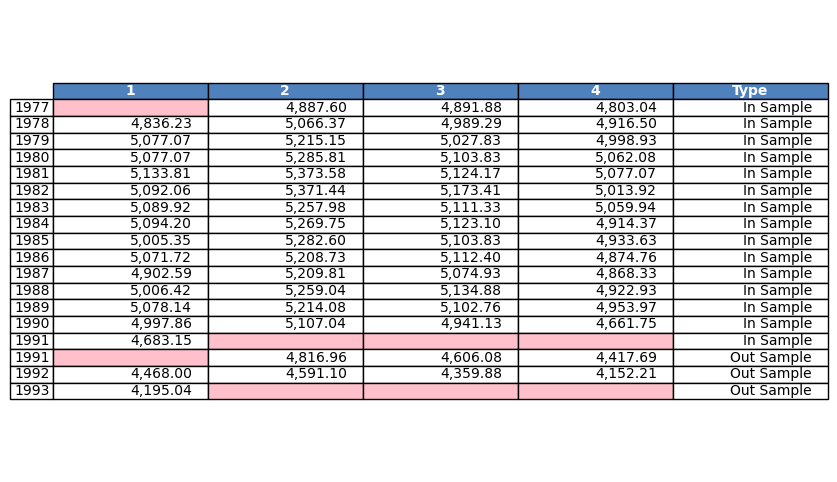


Data saved to c:\LeonS_Forcasting\Dataset\Figures\1_Figure_1Bis_in_sample_out_sample_data_styled.tiff as a styled TIFF file


In [4]:
import matplotlib.pyplot as plt

try:
   

    # Create a DataFrame for in-sample data
    in_sample_df = in_sample_ts.to_frame(name="Value")
    in_sample_df['Year'] = in_sample_df.index.year
    in_sample_df['Quarter'] = in_sample_df.index.quarter
    in_sample_pivot = in_sample_df.pivot(index='Year', columns='Quarter', values='Value')

    # Create a DataFrame for out-sample data
    out_sample_df = out_sample_ts.to_frame(name="Value")
    out_sample_df['Year'] = out_sample_df.index.year
    out_sample_df['Quarter'] = out_sample_df.index.quarter
    out_sample_pivot = out_sample_df.pivot(index='Year', columns='Quarter', values='Value')

    # Combine in-sample and out-sample data
    in_sample_pivot['Type'] = 'In Sample'
    out_sample_pivot['Type'] = 'Out Sample'
    combined_df = pd.concat([in_sample_pivot, out_sample_pivot], axis=0).fillna("")

    # Format numbers with commas as thousands separators
    combined_df = combined_df.applymap(lambda x: f"{x:,.2f}" if isinstance(x, (int, float)) else x)

    # Create a figure and axis for the table
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')  # Hide the axes

    # Draw the table
    table = ax.table(
        cellText=combined_df.values,
        colLabels=combined_df.columns,
        rowLabels=combined_df.index,
        loc='center'
    )

    # Style the header cells and empty cells
    for (i, j), cell in table.get_celld().items():
        if i == 0:  # Header cells
            cell.set_fontsize(16)
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#4F81BD')  # Beautiful blue color for the header
        elif cell.get_text().get_text() == "":  # Empty cells
            cell.set_facecolor('#FFC0CB')  # Pink color for empty cells
        else:  # Data cells
            cell.set_fontsize(12)

    # Save as TIFF file
    save_path = r'c:\LeonS_Forcasting\Dataset\Figures\1_Figure_1Bis_in_sample_out_sample_data_styled.tiff'
    plt.savefig(save_path, format='tiff', dpi=300)  # Save as TIFF with high resolution

    # Display the table in the notebook
    plt.show()  # Show the figure in the Jupyter Notebook

    print(f"\nData saved to {save_path} as a styled TIFF file")

except KeyError as e:
    print(f"Missing column in DataFrame: {e}")
except ValueError as ve:
    print(f"Value error: {ve}")
except Exception as ex:
    print(f"An unexpected error occurred: {ex}")


### 'Maximum', '3rd Quartile', 'Mean', 'Median', '1st Quartile', 'Minimum'

In [5]:

import openpyxl
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Font



# Calculate summary statistics for in-sample data
summary_stats = {
    'Statistic': ['Maximum', '3rd Quartile', 'Mean', 'Median', '1st Quartile', 'Minimum'],
    'Value': [
        round(in_sample_ts.max(), 2),
        round(in_sample_ts.quantile(0.75), 2),
        round(in_sample_ts.mean(), 2),
        round(in_sample_ts.median(), 2),
        round(in_sample_ts.quantile(0.25), 2),
        round(in_sample_ts.min(), 2)
    ]
}

# Create a DataFrame from the summary statistics
summary_df = pd.DataFrame(summary_stats)

# Specify the path for saving the Excel file
excel_file_path = r'c:\LeonS_Forcasting\Dataset\Figures\2_Figure_2bis_in_sample_out_sample_data.xlsx'

# Save DataFrame to Excel
with pd.ExcelWriter(excel_file_path, engine='openpyxl') as writer:
    summary_df.to_excel(writer, index=False, sheet_name='Summary Stats')

    # Access the workbook and worksheet to modify font
    workbook = writer.book
    worksheet = writer.sheets['Summary Stats']
    
    # Apply Cambria font to all cells
    cambria_font = Font(name='Cambria')
    for row in worksheet.iter_rows():
        for cell in row:
            cell.font = cambria_font

# Confirmation message
print(f"Summary statistics saved to {excel_file_path} with Cambria font.")
 
# Display the summary statistics
print(summary_df)


Summary statistics saved to c:\LeonS_Forcasting\Dataset\Figures\2_Figure_2bis_in_sample_out_sample_data.xlsx with Cambria font.
      Statistic    Value
0       Maximum  5373.58
1  3rd Quartile  5126.58
2          Mean  5057.69
3        Median  5077.07
4  1st Quartile  4950.76
5       Minimum  4661.75


#### Create a Tiff image for the table 

Summary statistics saved to c:\LeonS_Forcasting\Dataset\Figures\2_Figure_2Bis_in_sample_summary_statistics.xlsx with Cambria font and styled table.


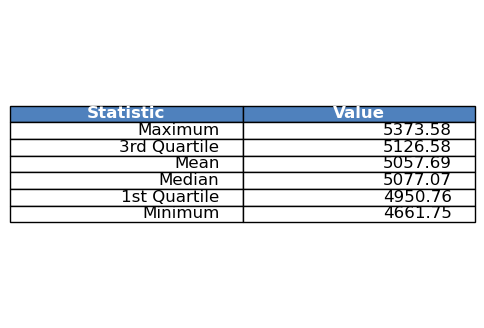


Summary statistics table saved to c:\LeonS_Forcasting\Dataset\Figures\2_Figure_2_in_sample_summary_statistics.tiff as a styled TIFF file.


In [6]:

from openpyxl import Workbook
from openpyxl.styles import Font, PatternFill

# Calculate summary statistics for in-sample data
summary_stats = {
    'Statistic': ['Maximum', '3rd Quartile', 'Mean', 'Median', '1st Quartile', 'Minimum'],
    'Value': [
        round(in_sample_ts.max(), 2),
        round(in_sample_ts.quantile(0.75), 2),
        round(in_sample_ts.mean(), 2),
        round(in_sample_ts.median(), 2),
        round(in_sample_ts.quantile(0.25), 2),
        round(in_sample_ts.min(), 2)
    ]
}

# Create a DataFrame from the summary statistics
summary_df = pd.DataFrame(summary_stats)

# Specify the path for saving the Excel file
excel_file_path = r'c:\LeonS_Forcasting\Dataset\Figures\2_Figure_2Bis_in_sample_summary_statistics.xlsx'

# Save the summary DataFrame to Excel with formatting
with pd.ExcelWriter(excel_file_path, engine='openpyxl') as writer:
    summary_df.to_excel(writer, index=False, sheet_name='Summary Stats')
    
    # Access the workbook and worksheet to apply formatting
    workbook = writer.book
    worksheet = writer.sheets['Summary Stats']
    
    # Apply Cambria font to all cells
    cambria_font = Font(name='Cambria')
    for row in worksheet.iter_rows():
        for cell in row:
            cell.font = cambria_font

    # Apply header styling: blue background with white bold text
    header_fill = PatternFill(start_color="4F81BD", end_color="4F81BD", fill_type="solid")
    for cell in worksheet[1]:  # Header row is the first row
        cell.font = Font(name='Cambria', bold=True, color="FFFFFF")  # White bold text
        cell.fill = header_fill

# Confirmation message for Excel saving
print(f"Summary statistics saved to {excel_file_path} with Cambria font and styled table.")

# Create TIFF image with the same style

# Create a figure and axis for the table
fig, ax = plt.subplots(figsize=(6, 4))  # Adjust the size as needed
ax.axis('off')  # Hide the axes

# Draw the table in matplotlib
table = ax.table(
    cellText=summary_df.values,
    colLabels=summary_df.columns,
    loc='center'
)

# Style the header cells and data cells
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Header cells
        cell.set_fontsize(14)
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#4F81BD')  # Blue header background
    else:  # Data cells
        cell.set_fontsize(12)
        # Cambria font styling is not directly supported here; using default font

# Specify the path for saving the TIFF image
tiff_file_path = r'c:\LeonS_Forcasting\Dataset\Figures\2_Figure_2_in_sample_summary_statistics.tiff'

# Save the table as a TIFF file with high resolution
plt.savefig(tiff_file_path, format='tiff', dpi=300)

# Display the table in the notebook
plt.show()

print(f"\nSummary statistics table saved to {tiff_file_path} as a styled TIFF file.")


#### In Sample and Out of Sample Plot

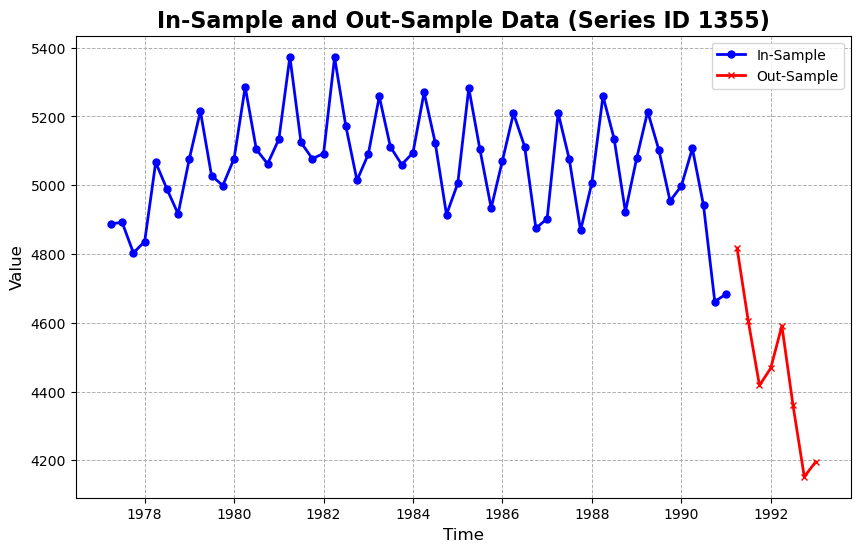

Plot saved to C:\LeonS_Forcasting\Dataset\Figures\3_Figures_3_in_sample_out_sample_plot.tiff


In [7]:

# Convert the PeriodIndex to DatetimeIndex for both in-sample and out-sample
in_sample_ts.index = in_sample_ts.index.to_timestamp()
out_sample_ts.index = out_sample_ts.index.to_timestamp()


# Function to plot in-sample and out-sample data
def plot_in_out_sample(in_sample_data, out_sample_data, title, xlabel, ylabel, save_path):
    plt.figure(figsize=(10, 6))
    
    # Plot in-sample data
    plt.plot(in_sample_data, color='blue', label='In-Sample', linewidth=2, marker='o', markersize=5)
    
    # Plot out-sample data
    plt.plot(out_sample_data, color='red', label='Out-Sample', linewidth=2, marker='x', markersize=5)
    
    # Add title and labels
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    
    # Display legend
    plt.legend(loc='best')
    
    # Enhance gridlines
    plt.grid(True, which='both', linestyle='--', linewidth=0.7)
    
    # Save the plot as a TIFF file
    plt.savefig(save_path, format='tiff', dpi=300)
    
    # Show plot
    plt.show()
    
    # Print confirmation message
    print(f"Plot saved to {save_path}")

# Define plot parameters
plot_save_path = r'C:\LeonS_Forcasting\Dataset\Figures\3_Figures_3_in_sample_out_sample_plot.tiff'
plot_in_out_sample(
    in_sample_data=in_sample_ts,
    out_sample_data=out_sample_ts,
    title='In-Sample and Out-Sample Data (Series ID 1355)',
    xlabel='Time',
    ylabel='Value',
    save_path=plot_save_path
)


##### Seasonal Plot

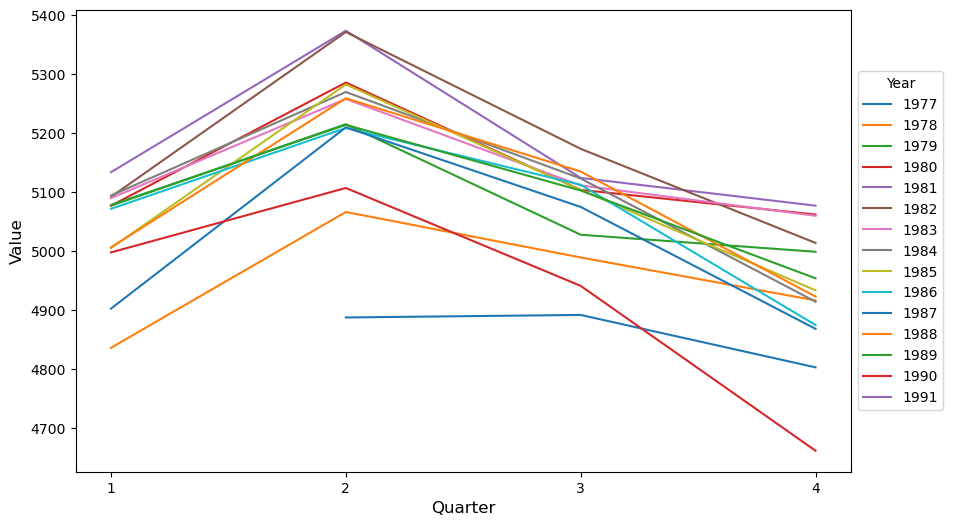

Seasonal plot saved to C:\LeonS_Forcasting\Dataset\Figures\4_Figure_4_seasonal_plot.tiff


In [8]:
import seaborn as sns


# Create a seasonal plot using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=in_sample_df, x='Quarter', y='Value', hue='Year', palette='tab10')

# Set the x-ticks to display only 1, 2, 3, and 4
plt.xticks([1, 2, 3, 4], labels=['1', '2', '3', '4'])

# Add title and customize plot aesthetics
plt.title('', fontsize=16, fontweight='bold')
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Value', fontsize=12)

# Move the legend to the right of the plot
plt.legend(title='Year', loc='center left', bbox_to_anchor=(1, 0.5))

# Define the file path for the TIFF file
tiff_file_path = r'C:\LeonS_Forcasting\Dataset\Figures\4_Figure_4_seasonal_plot.tiff'

# Save the plot as a TIFF file with high resolution (DPI)
plt.savefig(tiff_file_path, format='tiff', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Confirmation message
print(f"Seasonal plot saved to {tiff_file_path}")


##### BoxPlot

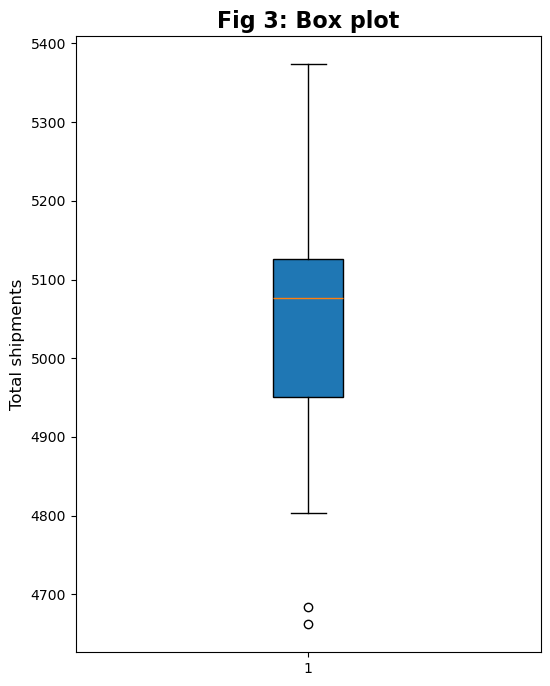

Box plot saved to C:\LeonS_Forcasting\Dataset\Figures\5_Figure_5_box_plot.tiff


In [9]:
# Create the box plot
plt.figure(figsize=(6, 8))
plt.boxplot(in_sample_ts, vert=True, patch_artist=True)

# Add title and labels
plt.title("Fig 3: Box plot", fontsize=16, fontweight='bold')
plt.ylabel("Total shipments", fontsize=12)

# Define the file path for the TIFF file
tiff_file_path = r'C:\LeonS_Forcasting\Dataset\Figures\5_Figure_5_box_plot.tiff'

# Save the plot as a TIFF file
plt.savefig(tiff_file_path, format='tiff', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Confirmation message
print(f"Box plot saved to {tiff_file_path}")


##### Seasonal Subseries Plot

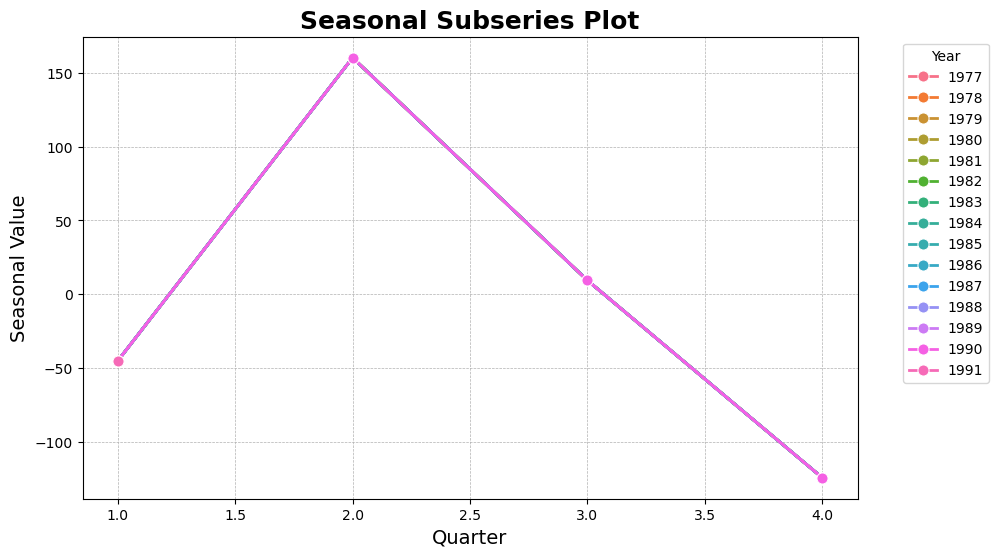

Seasonal subseries plot saved to C:\LeonS_Forcasting\Dataset\Figures\6_Figure_6_seasonal_subseries_plot.tiff


In [10]:

from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series to extract the seasonal component
decomposition = seasonal_decompose(in_sample_ts, model='additive', period=4)  

# Create a DataFrame to store the seasonal component
seasonal_df = pd.DataFrame({
    'Value': decomposition.seasonal,
    'Quarter': in_sample_ts.index.quarter,
    'Year': in_sample_ts.index.year
})

# Create a seasonal subseries plot with enhanced readability
plt.figure(figsize=(10, 6))

# Use a color palette for better distinction between years
palette = sns.color_palette("husl", len(seasonal_df['Year'].unique()))

# Create the line plot with larger markers and thicker lines
sns.lineplot(x='Quarter', y='Value', hue='Year', data=seasonal_df, 
             marker='o', linewidth=2, markersize=8, palette=palette)

# Add grid to enhance readability
plt.grid(True, linestyle='--', linewidth=0.5)

# Adjust the title and labels
plt.title('Seasonal Subseries Plot', fontsize=18, fontweight='bold')
plt.xlabel('Quarter', fontsize=14)
plt.ylabel('Seasonal Value', fontsize=14)

# Move the legend outside the plot for clarity
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

# Define the file path for the TIFF file
tiff_file_path = r'C:\LeonS_Forcasting\Dataset\Figures\6_Figure_6_seasonal_subseries_plot.tiff'

# Save the plot as a TIFF file with a high DPI for better clarity
plt.savefig(tiff_file_path, format='tiff', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Confirmation message
print(f"Seasonal subseries plot saved to {tiff_file_path}")

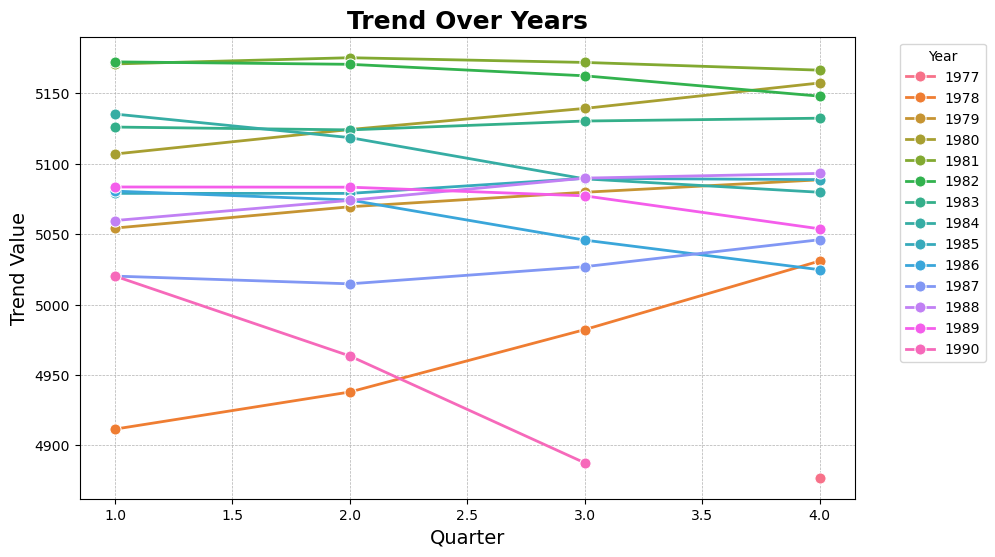

Trend component plot saved to C:\LeonS_Forcasting\Dataset\Figures\7_Figure7_trend_component_plot.tiff


In [11]:
# Decompose the time series to extract the trend component
decomposition = seasonal_decompose(in_sample_ts, model='additive', period=4)   
# Create a DataFrame to store the trend component
trend_df = pd.DataFrame({
    'Value': decomposition.trend,
    'Quarter': in_sample_ts.index.quarter,
    'Year': in_sample_ts.index.year
}).dropna()  # Drop NaN values from trend component (at the beginning and end due to decomposition)

# Create a plot for the trend component over the years
plt.figure(figsize=(10, 6))

# Use a color palette for better distinction between years
palette = sns.color_palette("husl", len(trend_df['Year'].unique()))

# Create the line plot with larger markers and thicker lines
sns.lineplot(x='Quarter', y='Value', hue='Year', data=trend_df, 
             marker='o', linewidth=2, markersize=8, palette=palette)

# Add grid to enhance readability
plt.grid(True, linestyle='--', linewidth=0.5)

# Adjust the title and labels
plt.title('Trend Over Years', fontsize=18, fontweight='bold')
plt.xlabel('Quarter', fontsize=14)
plt.ylabel('Trend Value', fontsize=14)

# Move the legend outside the plot for clarity
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

# Define the file path for the TIFF file
tiff_file_path = r'C:\LeonS_Forcasting\Dataset\Figures\7_Figure7_trend_component_plot.tiff'

# Save the plot as a TIFF file with a high DPI for better clarity
plt.savefig(tiff_file_path, format='tiff', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Confirmation message
print(f"Trend component plot saved to {tiff_file_path}")


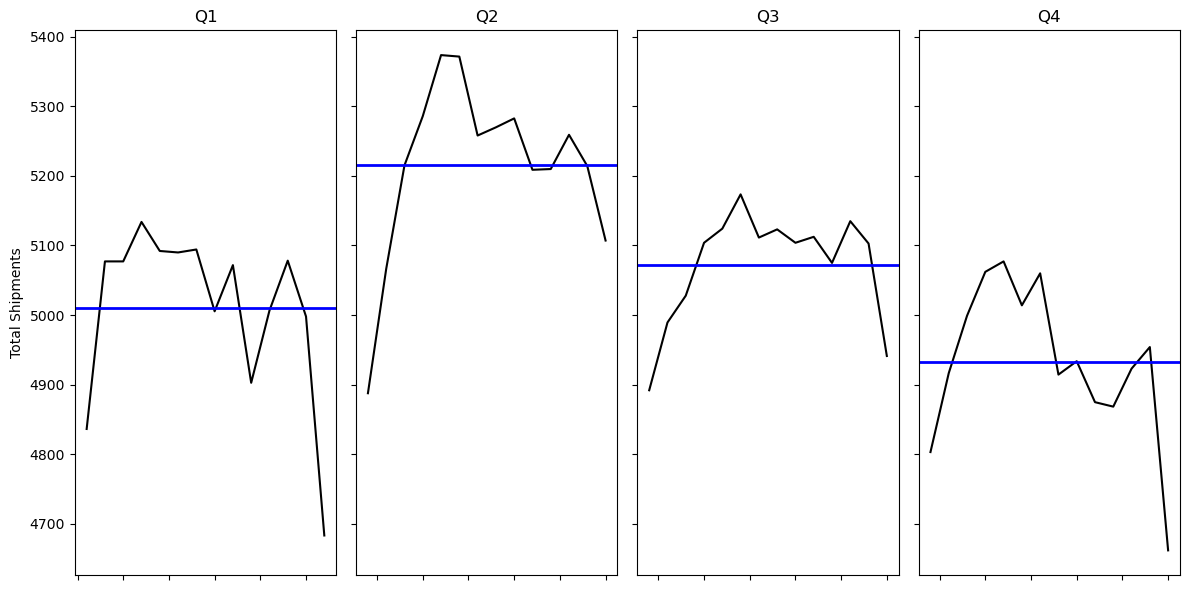

Seasonal subseries plot saved to C:\LeonS_Forcasting\Dataset\Figures\8_Fig_8_seasonal_subseries_plot.tiff


In [12]:

# Decompose the time series to extract the seasonal component
decomposition = seasonal_decompose(in_sample_ts, model='additive', period=4)  

# Create a DataFrame to store the seasonal component
seasonal_df = pd.DataFrame({
    'Value': in_sample_ts.values,
    'Quarter': in_sample_ts.index.quarter,
    'Year': in_sample_ts.index.year
})

# Set up the subplots for each quarter (Q1, Q2, Q3, Q4)
fig, axes = plt.subplots(1, 4, sharey=True, figsize=(12, 6))

# Define quarters and titles for subplots
quarters = [1, 2, 3, 4]
titles = ['Q1', 'Q2', 'Q3', 'Q4']

# Plot for each quarter separately
for i, quarter in enumerate(quarters):
    # Filter the data for the specific quarter
    quarter_data = seasonal_df[seasonal_df['Quarter'] == quarter]
    
    # Plot the data points for the quarter
    axes[i].plot(quarter_data['Year'], quarter_data['Value'], color='black')
    
    # Plot the mean line for the quarter
    axes[i].axhline(y=quarter_data['Value'].mean(), color='blue', linestyle='-', linewidth=2)
    
    # Set the title for each subplot
    axes[i].set_title(titles[i])
    
    # Remove x-axis labels (years) for all subplots
    axes[i].tick_params(axis='x', labelbottom=False)

# Add a common y-axis label
axes[0].set_ylabel('Total Shipments')

# Adjust layout to avoid overlap
plt.tight_layout()

# Define the file path for the TIFF file
tiff_file_path = r'C:\LeonS_Forcasting\Dataset\Figures\8_Fig_8_seasonal_subseries_plot.tiff'

# Save the plot as a TIFF file
plt.savefig(tiff_file_path, format='tiff', dpi=300)

# Show the plot
plt.show()

# Confirmation message
print(f"Seasonal subseries plot saved to {tiff_file_path}")


### Decomposition of Additive and Multiplicative Time Series:

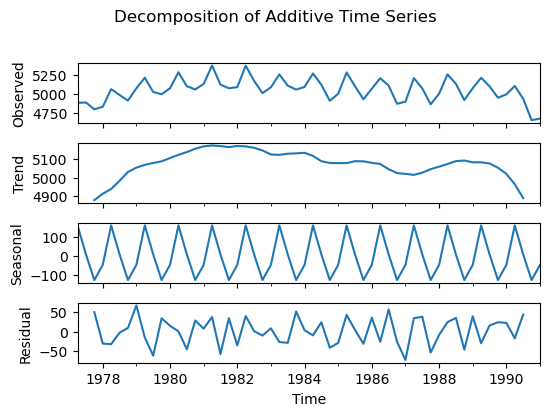

Additive decomposition plot saved to C:\LeonS_Forcasting\Dataset\Figures\9_Figure9_decomposition_additive.tiff


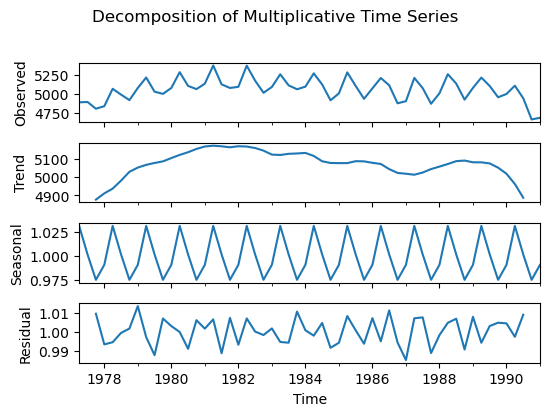

Multiplicative decomposition plot saved to C:\LeonS_Forcasting\Dataset\Figures\10_Figure10_decomposition_multiplicative.tiff


In [13]:

# Additive Decomposition
def plot_additive_decomposition(series, save_path):
    decomposition = seasonal_decompose(series, model='additive', period=4)  
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(5.6, 4.2), sharex=True)  # Adjusted size
    fig.suptitle("Decomposition of Additive Time Series")

    # Plot the decomposed components
    decomposition.observed.plot(ax=ax1, legend=False)
    ax1.set_ylabel('Observed')

    decomposition.trend.plot(ax=ax2, legend=False)
    ax2.set_ylabel('Trend')

    decomposition.seasonal.plot(ax=ax3, legend=False)
    ax3.set_ylabel('Seasonal')

    decomposition.resid.plot(ax=ax4, legend=False)
    ax4.set_ylabel('Residual')
    ax4.set_xlabel('Time')

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout for title
    plt.savefig(save_path, format='tiff', dpi=300)
    plt.show()
    print(f"Additive decomposition plot saved to {save_path}")

# Multiplicative Decomposition
def plot_multiplicative_decomposition(series, save_path):
    decomposition = seasonal_decompose(series, model='multiplicative', period=4)  
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(5.6, 4.2), sharex=True)  # Adjusted size
    fig.suptitle("Decomposition of Multiplicative Time Series")

    # Plot the decomposed components
    decomposition.observed.plot(ax=ax1, legend=False)
    ax1.set_ylabel('Observed')

    decomposition.trend.plot(ax=ax2, legend=False)
    ax2.set_ylabel('Trend')

    decomposition.seasonal.plot(ax=ax3, legend=False)
    ax3.set_ylabel('Seasonal')

    decomposition.resid.plot(ax=ax4, legend=False)
    ax4.set_ylabel('Residual')
    ax4.set_xlabel('Time')

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout for title
    plt.savefig(save_path, format='tiff', dpi=300)
    plt.show()
    print(f"Multiplicative decomposition plot saved to {save_path}")

# File paths to save the plots
additive_file_path = r'C:\LeonS_Forcasting\Dataset\Figures\9_Figure9_decomposition_additive.tiff'
multiplicative_file_path = r'C:\LeonS_Forcasting\Dataset\Figures\10_Figure10_decomposition_multiplicative.tiff'

# Generate and save the decomposition plots
plot_additive_decomposition(in_sample_ts, additive_file_path)
plot_multiplicative_decomposition(in_sample_ts, multiplicative_file_path)


## Seasonal Peaks and Troughs: ### The series exhibits strong seasonal peaks around the
### second quarter (Q2) and significant troughs around the fourth quarter (Q4). This
### pattern suggests a higher level of activity or shipments during Q2, with a decline
### towards the end of the year in Q4. This cyclical behavior indicates a consistent
### demand pattern, possibly linked to industry-specific cycles, consumer behavior, or
### other microeconomic factors

## Year-to-Year Variability: ### While the general seasonal pattern remains consistent,
### there is noticeable variability in the magnitude of shipments across different years.
### Specific years display sharper peaks or deeper troughs, indicating variability in
### seasonal effects possibly due to external factors such as market conditions, economic
### policies, or changes in demand dynamics. This variability can also be attributed to
### anomalies or extraordinary events impacting the supply chain or market conditions.

## The Box Plot ### provides a statistical summary of shipment data, highlighting
### the median (slightly above 5100), interquartile range (5000-5200), and outliers. The lower
### and upper whiskers extend just below 4750 and to 5350, respectively, with a notable outlier
### around 4700. This plot confirms findings from the seasonal and subseries plots, illustrating
### consistent variations and significant anomalies in shipment volumes. 

## The Seasonal Subseries Plot ### reveals critical shipment patterns across
### quarters. Q1 shows stable trends with significant fluctuations and a notable low outlier. Q2
### indicates higher activity with substantial variation and significant peaks. Q3 demonstrates
### consistent shipment volumes with fewer outliers, suggesting predictability. Q4 reflects a
### seasonal decline with a significant end-quarter drop, highlighting anomalies. 

## The multiplicative decomposition ### better
### captures proportional seasonal variations and handles relative changes in data, as evidenced
### by the consistent trend, oscillating seasonal component, and normalized residuals around 1.
### This approach reveals that seasonal effects are multiplicative and proportional to the level
### of the time series. In contrast, the additive decomposition shows constant
### seasonal effects and absolute residual deviations around zero, which fails to account for the
### relative variability in the data. 

## Transition to Regression Modeling

In [14]:

from sklearn.metrics import mean_squared_error



# Decompose the time series (Additive and Multiplicative)
decomp_additive = seasonal_decompose(in_sample_ts, model='additive', period=4)  # Quarterly data
decomp_multiplicative = seasonal_decompose(in_sample_ts, model='multiplicative', period=4)  # Quarterly data

# Reconstructed time series (Additive)
reconstructed_additive = decomp_additive.trend + decomp_additive.seasonal

# Reconstructed time series (Multiplicative)
reconstructed_multiplicative = decomp_multiplicative.trend * decomp_multiplicative.seasonal

# Ensure all series have the same length by dropping NaN values in a consistent manner
in_sample_ts_cleaned = in_sample_ts.dropna()
reconstructed_additive_cleaned = reconstructed_additive.dropna()
reconstructed_multiplicative_cleaned = reconstructed_multiplicative.dropna()

# Align the indices of the original and reconstructed series
aligned_additive = in_sample_ts_cleaned.loc[reconstructed_additive_cleaned.index]
aligned_multiplicative = in_sample_ts_cleaned.loc[reconstructed_multiplicative_cleaned.index]

# Calculate MSE for the additive decomposition
mse_additive = mean_squared_error(aligned_additive, reconstructed_additive_cleaned)

# Calculate MSE for the multiplicative decomposition
mse_multiplicative = mean_squared_error(aligned_multiplicative, reconstructed_multiplicative_cleaned)


# Print the MSE values with 3 decimal places
print(f"MSE for Additive Decomposition: {mse_additive:.3f}")
print(f"MSE for Multiplicative Decomposition: {mse_multiplicative:.3f}")



MSE for Additive Decomposition: 1222.971
MSE for Multiplicative Decomposition: 1214.924


##### MSE Results 

MSE results table saved as an SVG image at C:\LeonS_Forcasting\Dataset\Figures\11_mse_results_styled_final.svg


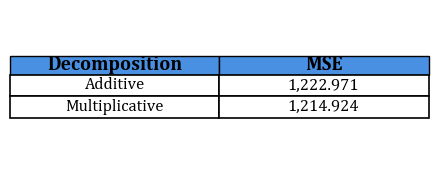

In [15]:

from matplotlib.font_manager import FontProperties


mse_df = pd.DataFrame({
    'Decomposition': ['Additive', 'Multiplicative'],
    'MSE': [f"{mse_additive:,.3f}", f"{mse_multiplicative:,.3f}"]  # Format with commas and 3 decimals
})

# Define font and color properties
font_header = FontProperties(family='Cambria', weight='bold', size=14)  # Slightly smaller font for header
font_body = FontProperties(family='Cambria', size=12)
header_color = '#4a90e2'  # Blue color for header
cell_color = 'white'
text_color = 'black'

# Plot and style the table
fig, ax = plt.subplots(figsize=(4.5, 2))  # Adjust figure width slightly for more space
ax.axis('tight')
ax.axis('off')

# Convert data to strings for display and add styling
table_data = ax.table(cellText=mse_df.values, colLabels=mse_df.columns, loc='center', cellLoc='center')
table_data.auto_set_font_size(False)
table_data.set_fontsize(12)
table_data.scale(1.2, 1.3)  # Adjusted scaling for better fit

# Set header style and increase header row height
for j in range(len(mse_df.columns)):
    cell = table_data[0, j]
    cell.set_text_props(fontproperties=font_header, color=text_color)
    cell.set_facecolor(header_color)
    cell.set_height(0.12)  # Increased header row height for improved alignment

# Set body style
for i in range(1, len(mse_df) + 1):
    for j in range(len(mse_df.columns)):
        cell = table_data[i, j]
        cell.set_text_props(fontproperties=font_body)
        cell.set_facecolor(cell_color)
        cell.set_edgecolor("black")
        cell.set_linewidth(1.2)  # Thicker cell borders

# Save the styled table as an SVG file
svg_file_path = r'C:\LeonS_Forcasting\Dataset\Figures\11_mse_results_styled_final.svg'
plt.savefig(svg_file_path, format='svg', bbox_inches='tight')

# Confirmation message
print(f"MSE results table saved as an SVG image at {svg_file_path}")


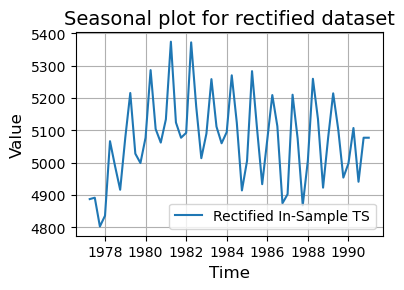

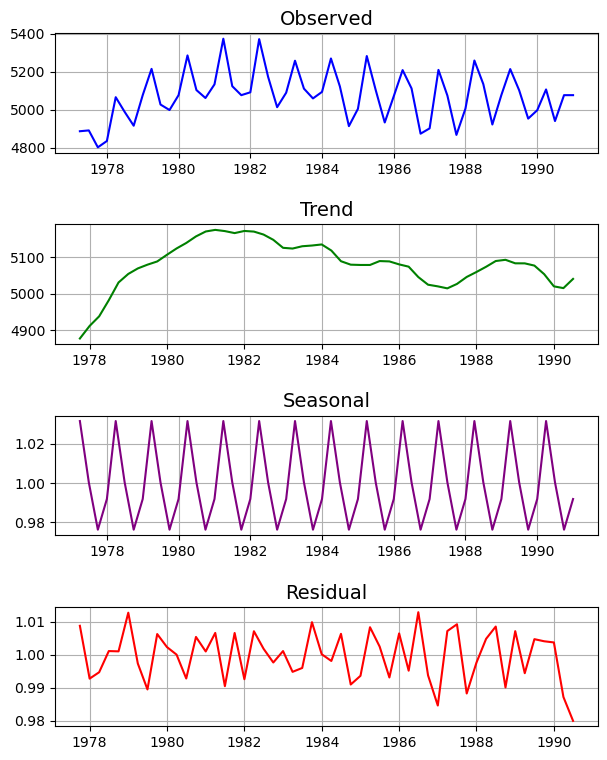

SVG plots with rectified seasonal pattern and decomposition saved.


In [16]:

from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np





# rectification by removing outliers 
Q1 = in_sample_ts.quantile(0.25)
Q3 = in_sample_ts.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
in_sample_ts_rectified = in_sample_ts.copy()
outliers = (in_sample_ts < lower_bound) | (in_sample_ts > upper_bound)
in_sample_ts_rectified[outliers] = in_sample_ts.median()

# Plot the seasonal pattern of the rectified dataset with reduced size
svg_file_path_seasonal = r'C:\LeonS_Forcasting\Dataset\Figures\12_rectified_seasonal_plot45.svg'

plt.figure(figsize=(7.2 * 0.55, 4.8 * 0.55))  # Reduced size by 45%
plt.plot(in_sample_ts_rectified.index, in_sample_ts_rectified, label='Rectified In-Sample TS')
plt.title("Seasonal plot for rectified dataset", fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.grid(True)  # Add gridlines
plt.legend()

# Save the seasonal plot as SVG
plt.savefig(svg_file_path_seasonal, format='svg')

# Display the plot inline in Jupyter
plt.show()

# Decompose the rectified dataset and save the plot with adjusted margins
svg_file_path_decomposition = r'C:\LeonS_Forcasting\Dataset\Figures\14_rectified_decomposition45.svg'

# Decompose the rectified time series
decomp_rectified = seasonal_decompose(in_sample_ts_rectified, model='multiplicative', period=4)

# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(7, 9))  # Increased figure size
plt.subplots_adjust(hspace=0.6)  # Increased spacing between subplots

# Observed
axes[0].plot(decomp_rectified.observed, color='blue')
axes[0].set_title('Observed', fontsize=14)
axes[0].grid(True)

# Trend
axes[1].plot(decomp_rectified.trend, color='green')
axes[1].set_title('Trend', fontsize=14)
axes[1].grid(True)

# Seasonal
axes[2].plot(decomp_rectified.seasonal, color='purple')
axes[2].set_title('Seasonal', fontsize=14)
axes[2].grid(True)

# Residual
axes[3].plot(decomp_rectified.resid, color='red')
axes[3].set_title('Residual', fontsize=14)
axes[3].grid(True)

# Save the decomposition plot as SVG
plt.savefig(svg_file_path_decomposition, format='svg')

# Display the decomposition plot inline in Jupyter
plt.show()

# Confirmation message
print("SVG plots with rectified seasonal pattern and decomposition saved.")


### It was applied a multiplicative decomposition, that is useful in seasonal datasets 

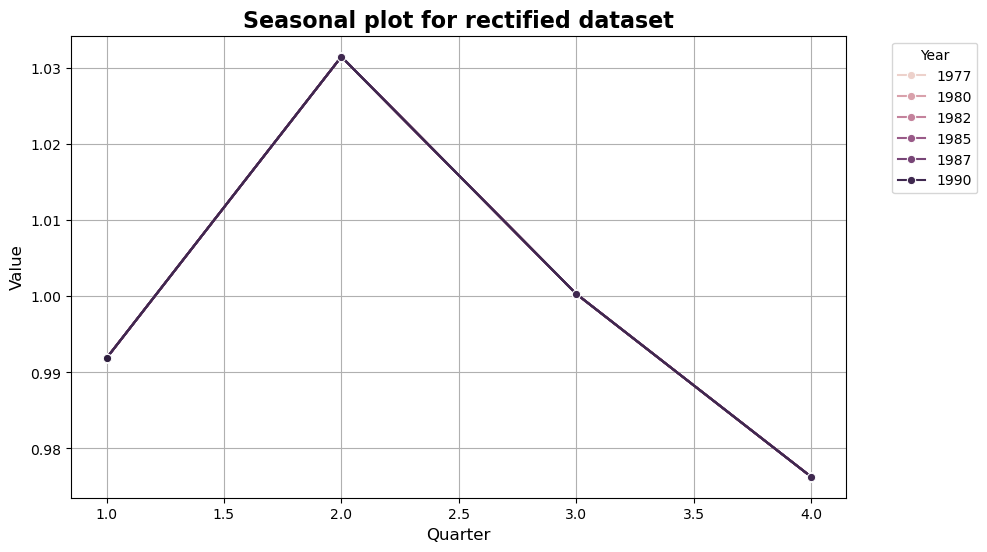

SVG plot saved to C:\LeonS_Forcasting\Dataset\Figures\15_rectified_seasonal_plot.svg


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the rectified time series to extract the seasonal component
decomp_rectified = seasonal_decompose(in_sample_ts_rectified, model='multiplicative', period=4)   

# Create a DataFrame to store the seasonal component for the rectified dataset
seasonal_df_rectified = pd.DataFrame({
    'Value': decomp_rectified.seasonal,
    'Quarter': in_sample_ts_rectified.index.quarter,
    'Year': in_sample_ts_rectified.index.year
})

# Step 6: Plot the seasonal pattern of the rectified dataset with a legend for the years
plt.figure(figsize=(10, 6))  # Define a larger figure size for clarity
sns.lineplot(x='Quarter', y='Value', hue='Year', data=seasonal_df_rectified, marker='o')

plt.title("Seasonal plot for rectified dataset", fontsize=16, fontweight='bold')
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move the legend to the right
plt.grid(True)  # Add gridlines for better readability

# Define the file path to save the seasonal plot
svg_file_path_seasonal = r'C:\LeonS_Forcasting\Dataset\Figures\15_rectified_seasonal_plot.svg'

# Save the plot as an SVG file
plt.savefig(svg_file_path_seasonal, format='svg')

# Display the plot inline in Jupyter
plt.show()

# Confirmation message
print(f"SVG plot saved to {svg_file_path_seasonal}")


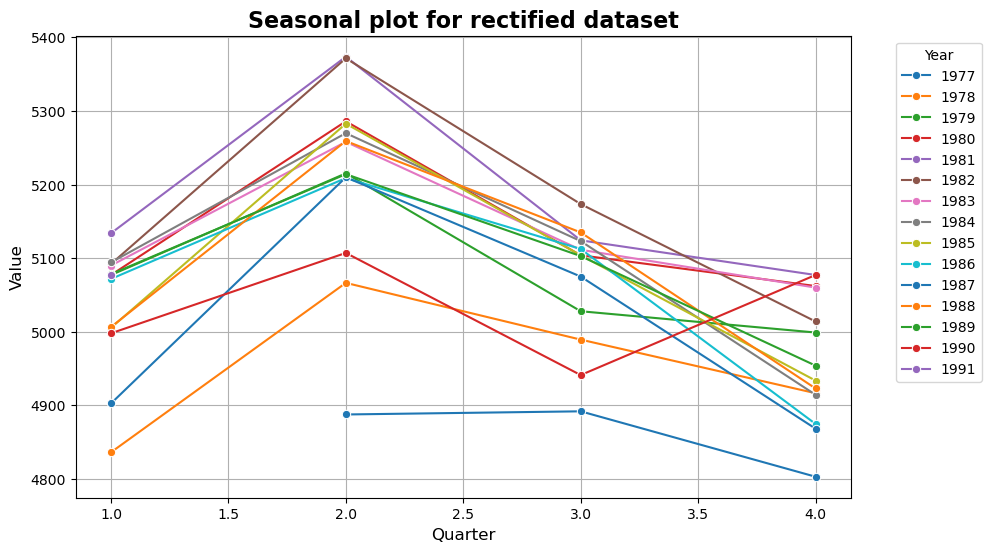

SVG plot saved to C:\LeonS_Forcasting\Dataset\Figures\16_rectified_seasonal_plot.svg


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the rectified time series to extract the seasonal component
decomp_rectified = seasonal_decompose(in_sample_ts_rectified, model='multiplicative', period=4)   
# Create a DataFrame to store the seasonal component for the rectified dataset
seasonal_df_rectified = pd.DataFrame({
    'Value': in_sample_ts_rectified,  # Instead of seasonal component, we use the actual rectified values
    'Quarter': in_sample_ts_rectified.index.quarter,
    'Year': in_sample_ts_rectified.index.year
})

# Step 6: Plot the seasonal pattern of the rectified dataset with a legend for the years
plt.figure(figsize=(10, 6))  # Define a larger figure size for clarity
sns.lineplot(x='Quarter', y='Value', hue='Year', data=seasonal_df_rectified, marker='o', palette="tab10")

plt.title("Seasonal plot for rectified dataset", fontsize=16, fontweight='bold')
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move the legend to the right
plt.grid(True)  # Add gridlines for better readability

# Define the file path to save the seasonal plot
svg_file_path_seasonal = r'C:\LeonS_Forcasting\Dataset\Figures\16_rectified_seasonal_plot.svg'

# Save the plot as an SVG file
plt.savefig(svg_file_path_seasonal, format='svg')

# Display the plot inline in Jupyter
plt.show()

# Confirmation message
print(f"SVG plot saved to {svg_file_path_seasonal}")


## Evaluation of Regression Models and Forecasting Accuracy

Styled results table saved as an SVG image at C:\LeonS_Forcasting\Dataset\Figures\17_compact_styled_results.svg
        Model   MAPE   MASE
0        fit1   2.56   0.90
1        fit2   3.19   1.12
2        fit3   1.96   0.69
3    fit_log1   2.58   0.90
4    fit_log2   3.20   1.12
5    fit_log3   1.96   0.69
6   fit_sqrt1   2.56   0.90
7   fit_sqrt2   3.19   1.12
8   fit_sqrt3   1.96   0.68
9     fit_bc1  97.18  35.21
10    fit_bc2  97.18  35.21
11    fit_bc3  97.19  35.21


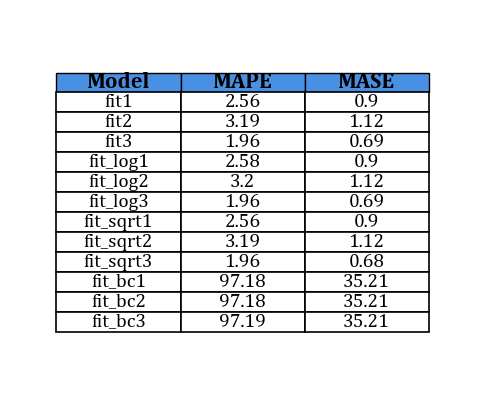

In [19]:
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from scipy.special import boxcox


# Splitting the data
h = 12  # Last 12 quarters for testing
y = in_sample_ts[:-h]
yv = in_sample_ts[-h:]

# Ensure all values are numeric and handle non-numeric or invalid values
y_positive = pd.to_numeric(y, errors='coerce').fillna(0).to_numpy()

# Fitting different models (Linear Regression)
def fit_linear_regression(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model

# Create trend and seasonal features
trend = np.arange(len(y)).reshape(-1, 1)
season = pd.get_dummies(y.index.quarter)

# Fit different models
fit1 = fit_linear_regression(np.hstack([trend, season]), y)
fit2 = fit_linear_regression(trend, y)
fit3 = fit_linear_regression(season, y)

# Log transformation and fitting models
log_y_positive = np.log(y_positive + 1)  # Avoid log(0)
fit_log1 = fit_linear_regression(np.hstack([trend, season]), log_y_positive)
fit_log2 = fit_linear_regression(trend, log_y_positive)
fit_log3 = fit_linear_regression(season, log_y_positive)

# Sqrt transformation
fit_sqrt1 = fit_linear_regression(np.hstack([trend, season]), np.sqrt(y_positive))
fit_sqrt2 = fit_linear_regression(trend, np.sqrt(y_positive))
fit_sqrt3 = fit_linear_regression(season, np.sqrt(y_positive))

# Box-Cox transformation with lambda = 0.5
y_bc = boxcox(y_positive + 1, 0.5)
fit_bc1 = fit_linear_regression(np.hstack([trend, season]), y_bc)
fit_bc2 = fit_linear_regression(trend, y_bc)
fit_bc3 = fit_linear_regression(season, y_bc)

# Forecast function
def forecast(model, X_test):
    return model.predict(X_test)

# Future trend and seasonal features
trend_future = np.arange(len(y), len(y) + h).reshape(-1, 1)
season_future = pd.get_dummies(yv.index.quarter)

# Function to calculate MAPE and MASE
def mape(actual, forecast):
    return np.mean(np.abs((actual - forecast) / actual)) * 100

def mase(actual, forecast, training_data):
    return mean_absolute_error(actual, forecast) / mean_absolute_error(training_data[1:], training_data[:-1])

# Evaluate models and create the results DataFrame, rounding to 2 decimals
results = pd.DataFrame({
    "Model": ["fit1", "fit2", "fit3", "fit_log1", "fit_log2", "fit_log3", 
              "fit_sqrt1", "fit_sqrt2", "fit_sqrt3", "fit_bc1", "fit_bc2", "fit_bc3"],
    "MAPE": [
        mape(yv, forecast(fit1, np.hstack([trend_future, season_future]))),
        mape(yv, forecast(fit2, trend_future)),
        mape(yv, forecast(fit3, season_future)),
        mape(yv, np.exp(forecast(fit_log1, np.hstack([trend_future, season_future])))),
        mape(yv, np.exp(forecast(fit_log2, trend_future))),
        mape(yv, np.exp(forecast(fit_log3, season_future))),
        mape(yv, np.square(forecast(fit_sqrt1, np.hstack([trend_future, season_future])))),
        mape(yv, np.square(forecast(fit_sqrt2, trend_future))),
        mape(yv, np.square(forecast(fit_sqrt3, season_future))),
        mape(yv, forecast(fit_bc1, np.hstack([trend_future, season_future]))),
        mape(yv, forecast(fit_bc2, trend_future)),
        mape(yv, forecast(fit_bc3, season_future)),
    ],
    "MASE": [
        mase(yv, forecast(fit1, np.hstack([trend_future, season_future])), y),
        mase(yv, forecast(fit2, trend_future), y),
        mase(yv, forecast(fit3, season_future), y),
        mase(yv, np.exp(forecast(fit_log1, np.hstack([trend_future, season_future]))), y),
        mase(yv, np.exp(forecast(fit_log2, trend_future)), y),
        mase(yv, np.exp(forecast(fit_log3, season_future)), y),
        mase(yv, np.square(forecast(fit_sqrt1, np.hstack([trend_future, season_future]))), y),
        mase(yv, np.square(forecast(fit_sqrt2, trend_future)), y),
        mase(yv, np.square(forecast(fit_sqrt3, season_future)), y),
        mase(yv, forecast(fit_bc1, np.hstack([trend_future, season_future])), y),
        mase(yv, forecast(fit_bc2, trend_future), y),
        mase(yv, forecast(fit_bc3, season_future), y),
    ]
}).round(2)  # Round MAPE and MASE to 2 decimals

# Define table properties
font_header = FontProperties(family='Cambria', weight='bold', size=16)
font_body = FontProperties(family='Cambria', size=14)
header_color = '#4a90e2'  # Blue color for the header
cell_color = 'white'
text_color = 'black'

# Plot and save the results as an SVG image with custom styling
fig, ax = plt.subplots(figsize=(6, 5))  # Reduced figure size for compact columns
ax.axis('tight')
ax.axis('off')

# Convert data to strings and add styling
table_data = ax.table(cellText=results.values, colLabels=results.columns, loc='center', cellLoc='center')
table_data.auto_set_font_size(False)
table_data.set_fontsize(14)
table_data.scale(0.8, 1.2)  # Reduced width scaling for compact columns

# Set header style and increase header row height
for j in range(len(results.columns)):
    cell = table_data[0, j]
    cell.set_text_props(fontproperties=font_header, color=text_color)
    cell.set_facecolor(header_color)
    cell.set_height(0.05)  # Increase header row height

# Set body style
for i in range(1, len(results) + 1):
    for j in range(len(results.columns)):
        cell = table_data[i, j]
        cell.set_text_props(fontproperties=font_body)
        cell.set_facecolor(cell_color)
        cell.set_edgecolor("black")
        cell.set_linewidth(1.2)  # Increase cell border thickness for better readability

# Save the table as an SVG file
svg_file_path = r'C:\LeonS_Forcasting\Dataset\Figures\17_compact_styled_results.svg'
plt.savefig(svg_file_path, format='svg', bbox_inches='tight')

# Confirmation message
print(f"Styled results table saved as an SVG image at {svg_file_path}")
# Print the results DataFrame
print(results)

### Best Model: fit_sqrt3 is the top performer based on both MAPE and MASE.
### Close Contenders: fit3 and fit_log3 are very close in performance but fall just behind fit_sqrt3 because of their marginally higher MASE values.
### Recommendation: Focus on using fit_sqrt3 for forecasting, as it delivers the most accurate predictions while outperforming the naive baseline the most.

##### Forecast from Linear Regression with Seasonal Component

#### Use Monte Carlo simulation to account for randomness.

High-definition forecast plot saved to C:\LeonS_Forcasting\Dataset\Figures\17_forecast_high_def_sqrt3.svg


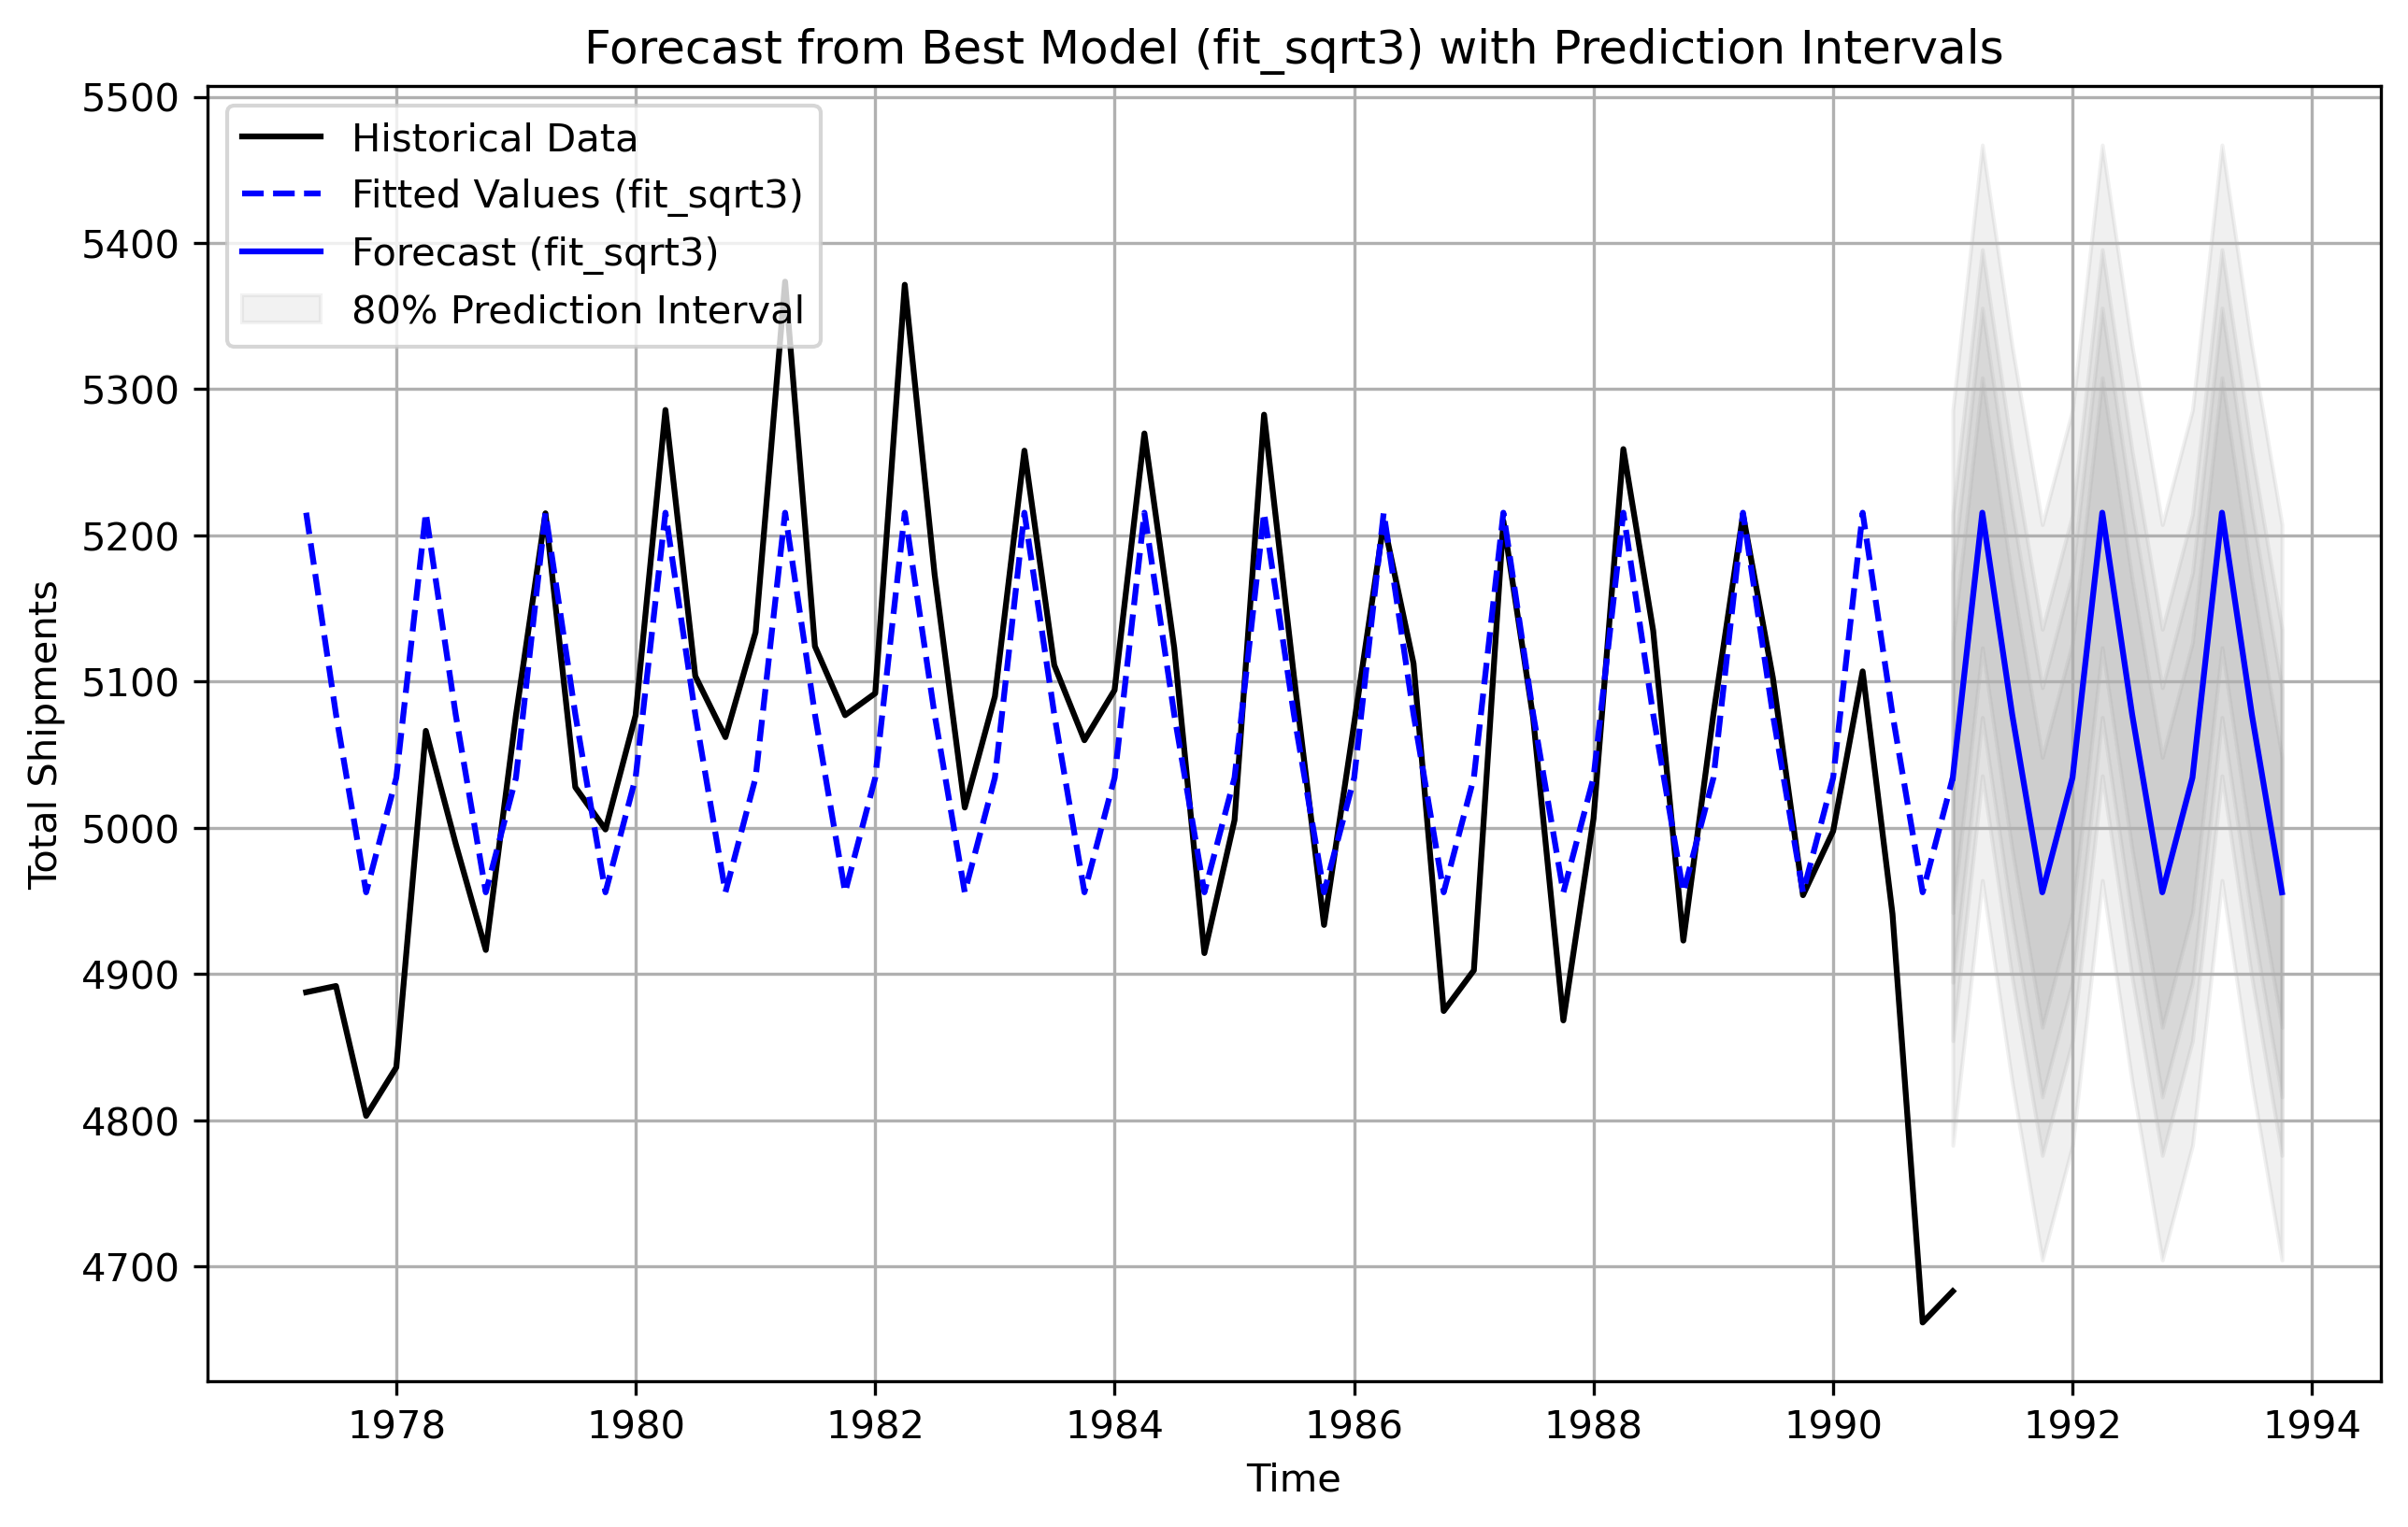

In [20]:

# Forecast horizon
h = 12  # Forecasting the next 12 quarters

# Prepare seasonal features and trend for the fitted model
trend_future = np.arange(len(in_sample_ts), len(in_sample_ts) + h).reshape(-1, 1)

# Correct the issue with adding quarters to a timestamp
season_future = pd.get_dummies(
    pd.period_range(start=in_sample_ts.index[-1] + pd.offsets.QuarterEnd(1), periods=h, freq='Q').quarter
)

# Prepare combined future features for "fit_sqrt3"
X_future = season_future  # Since "fit_sqrt3" is based only on seasonal components

# Generate forecasts using "fit_sqrt3"
y_forecast_sqrt = fit_sqrt3.predict(X_future)

# Reverse the square-root transformation to get original scale
y_forecast = np.square(y_forecast_sqrt)

# Generate fitted values for the in-sample period
season_in_sample = pd.get_dummies(in_sample_ts.index.quarter)
y_fitted_sqrt = fit_sqrt3.predict(season_in_sample)
y_fitted = np.square(y_fitted_sqrt)

# Calculate prediction intervals for the forecasts
residuals = in_sample_ts - y_fitted
std_error = np.std(residuals)  # Standard deviation of residuals
conf_levels = [0.8, 0.9, 0.95, 0.99]  # Confidence levels
intervals = {}

# Calculate prediction intervals based on the residuals
for conf_level in conf_levels:
    z_score = abs(np.percentile([np.random.normal() for _ in range(10000)], conf_level * 100))
    intervals[conf_level] = z_score * std_error

# Prepare forecast index
forecast_index = pd.period_range(start=in_sample_ts.index[-1] + pd.offsets.QuarterEnd(1), periods=h, freq="Q")

# Set up high-definition SVG plotting
svg_file_path = r'C:\LeonS_Forcasting\Dataset\Figures\17_forecast_high_def_sqrt3.svg'
plt.figure(figsize=(10, 6), dpi=300)  # High definition

# Plotting historical data, fitted values, and forecasts
plt.plot(in_sample_ts.index, in_sample_ts, color='black', label='Historical Data')
plt.plot(in_sample_ts.index, y_fitted, color='blue', linestyle='--', label='Fitted Values (fit_sqrt3)')
plt.plot(forecast_index.to_timestamp(), y_forecast, color='blue', label='Forecast (fit_sqrt3)')

# Adding prediction intervals
for conf_level, interval in intervals.items():
    plt.fill_between(
        forecast_index.to_timestamp(),
        y_forecast - interval,
        y_forecast + interval,
        color='grey',
        alpha=0.1 + 0.1 * (conf_level - 0.8),
        label=f'{int(conf_level * 100)}% Prediction Interval' if conf_level == 0.8 else ""
    )

# Labeling
plt.title("Forecast from Best Model (fit_sqrt3) with Prediction Intervals")
plt.xlabel("Time")
plt.ylabel("Total Shipments")
plt.legend(loc="upper left")

# Save plot as SVG
plt.grid(True)
plt.savefig(svg_file_path, format='svg', bbox_inches='tight')

# Confirmation message
print(f"High-definition forecast plot saved to {svg_file_path}")

# Display the plot inline (if running in a Jupyter Notebook or similar environment)
plt.show()


##### Residuals vs Fitted Values

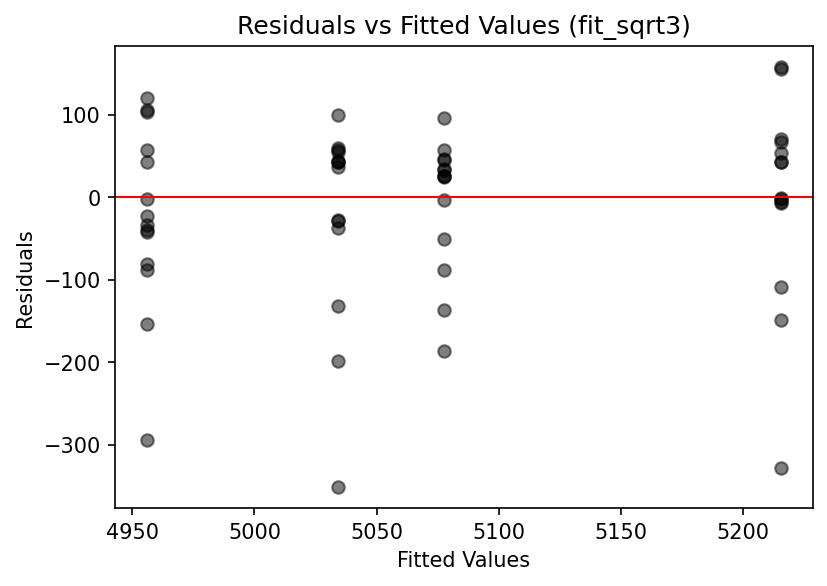

Durbin-Watson test: statistic=0.3525
Shapiro-Wilk test: statistic=0.8908, p-value=0.0001


<Figure size 900x600 with 0 Axes>

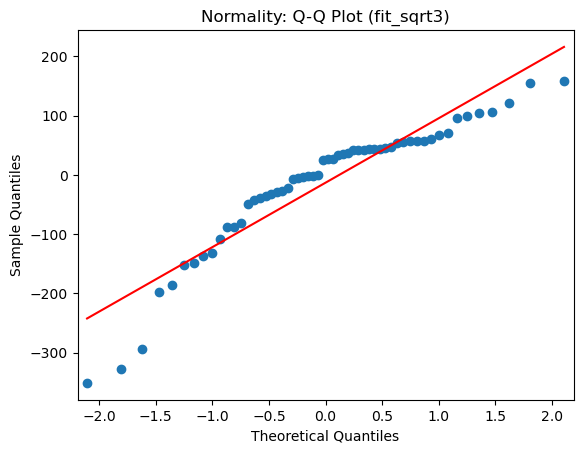

Breusch-Pagan test: statistic=1.2449, p-value=0.8707
MAPE: 3.51%
MASE: 1.2359


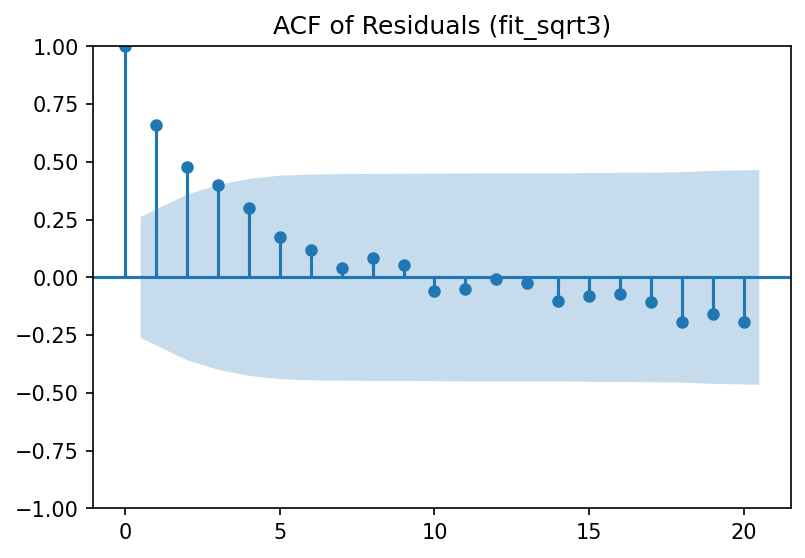

            Test  Statistic   P.Value
0  Durbin-Watson   0.352522       NaN
1   Shapiro-Wilk   0.890835  0.000106
2  Breusch-Pagan   1.244884  0.870655
3           MAPE   3.509228       NaN
4           MASE   1.235942       NaN
Plots and test results saved to 'C:\LeonS_Forcasting\Dataset\Figures\18_Figures'


In [21]:
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define base path and ensure the directory exists
base_path = r'C:\LeonS_Forcasting\Dataset\Figures\18_Figures'
os.makedirs(base_path, exist_ok=True)

# Define paths for SVG files
svg_file_path_residuals_fitted = os.path.join(base_path, "residuals_fitted_plot_sqrt3.svg")
svg_file_path_qqplot = os.path.join(base_path, "qqplot_sqrt3.svg")
svg_file_path_histogram = os.path.join(base_path, "histogram_residuals_sqrt3.svg")
svg_file_path_ts_residuals = os.path.join(base_path, "ts_residuals_sqrt3.svg")
svg_file_path_acf_residuals = os.path.join(base_path, "acf_residuals_sqrt3.svg")

# Define in-sample data
y = in_sample_ts

# Create seasonal features (quarterly dummies) for fit_sqrt3
X = pd.get_dummies(y.index.quarter)

# Residuals using fit_sqrt3
residuals = y - np.square(fit_sqrt3.predict(X))  # Reverse square-root transformation for fitted values

# Common figure size
fig_size = (6, 4)

# Residuals vs Fitted Values Plot
plt.figure(figsize=fig_size, dpi=150)
plt.scatter(np.square(fit_sqrt3.predict(X)), residuals, color='black', alpha=0.5)
plt.axhline(0, color='red', linewidth=1)
plt.title("Residuals vs Fitted Values (fit_sqrt3)")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.savefig(svg_file_path_residuals_fitted, format='svg', bbox_inches='tight')
plt.show()

# Independence: Durbin-Watson test
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson test: statistic={dw_stat:.4f}")

# Normality: Shapiro-Wilk test
shapiro_stat, shapiro_p_value = shapiro(residuals)
print(f"Shapiro-Wilk test: statistic={shapiro_stat:.4f}, p-value={shapiro_p_value:.4f}")

# Normality: Q-Q plot
plt.figure(figsize=fig_size, dpi=150)
qqplot(residuals, line='s')
plt.title("Normality: Q-Q Plot (fit_sqrt3)")
plt.savefig(svg_file_path_qqplot, format='svg', bbox_inches='tight')
plt.show()

# Equal Variance (Homoscedasticity): Breusch-Pagan test
X_with_const = sm.add_constant(X)  # Add constant for Breusch-Pagan test
bp_test_stat, bp_test_p_value, _, _ = het_breuschpagan(residuals, X_with_const)
print(f"Breusch-Pagan test: statistic={bp_test_stat:.4f}, p-value={bp_test_p_value:.4f}")

# Forecast and calculate MAPE and MASE
h = 12  # Define forecast horizon
yv = y[-h:]  # Out-of-sample actuals for testing
X_forecast = pd.get_dummies(pd.Series(np.tile(range(1, 5), h // 4 + 1)[:h]))  # Quarterly future dummies
y_forecast = np.square(fit_sqrt3.predict(X_forecast))  # Forecast values, reverse square-root transformation

# MAPE Calculation
mape_value = np.mean(np.abs((yv - y_forecast) / yv)) * 100
print(f"MAPE: {mape_value:.2f}%")

# MASE Calculation
mase_value = mean_absolute_error(yv, y_forecast) / mean_absolute_error(y[1:], y[:-1])
print(f"MASE: {mase_value:.4f}")

# Plot ACF of Residuals
fig = plt.figure(figsize=fig_size, dpi=150)
sm.graphics.tsa.plot_acf(residuals, lags=20, ax=fig.add_subplot(111))
plt.title("ACF of Residuals (fit_sqrt3)")
plt.savefig(svg_file_path_acf_residuals, format='svg', bbox_inches='tight')
plt.show()

# Display results summary
results_summary = pd.DataFrame({
    "Test": ["Durbin-Watson", "Shapiro-Wilk", "Breusch-Pagan", "MAPE", "MASE"],
    "Statistic": [dw_stat, shapiro_stat, bp_test_stat, mape_value, mase_value],
    "P.Value": [None, shapiro_p_value, bp_test_p_value, None, None]
})
print(results_summary)

print(f"Plots and test results saved to '{base_path}'")


### Put the data inside a table

Test results table saved as an SVG image at C:\LeonS_Forcasting\Dataset\Figures\18_Figures\test_results_table.svg


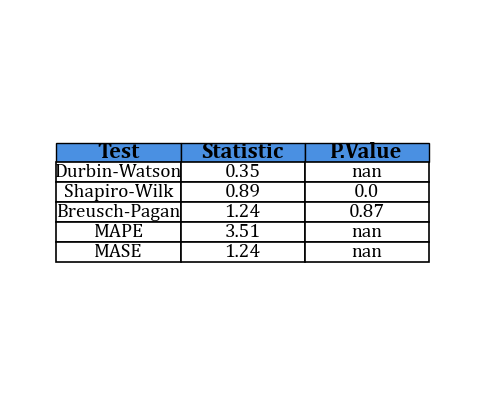

In [22]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Assuming `results_summary` is your DataFrame with the statistical test results
results_summary = results_summary.round(2)  # Round MAPE and MASE to 2 decimals

# Define table properties
font_header = FontProperties(family='Cambria', weight='bold', size=16)
font_body = FontProperties(family='Cambria', size=14)
header_color = '#4a90e2'  # Blue color for the header
cell_color = 'white'
text_color = 'black'

# Plot and save the results as an SVG image with custom styling
fig, ax = plt.subplots(figsize=(6, 5))  # Adjust size for display
ax.axis('tight')
ax.axis('off')

# Convert data to strings and add styling
table_data = ax.table(cellText=results_summary.values, colLabels=results_summary.columns, loc='center', cellLoc='center')
table_data.auto_set_font_size(False)
table_data.set_fontsize(14)
table_data.scale(0.8, 1.2)  # Reduced width scaling for compact columns

# Set header style and increase header row height
for j in range(len(results_summary.columns)):
    cell = table_data[0, j]
    cell.set_text_props(fontproperties=font_header, color=text_color)
    cell.set_facecolor(header_color)
    cell.set_height(0.05)  # Increase header row height

# Set body style
for i in range(1, len(results_summary) + 1):
    for j in range(len(results_summary.columns)):
        cell = table_data[i, j]
        cell.set_text_props(fontproperties=font_body)
        cell.set_facecolor(cell_color)
        cell.set_edgecolor("black")
        cell.set_linewidth(1.2)  # Increase cell border thickness for readability

# Save the table as an SVG file
svg_file_path_table = os.path.join(base_path, "test_results_table.svg")
plt.savefig(svg_file_path_table, format='svg', bbox_inches='tight')

print(f"Test results table saved as an SVG image at {svg_file_path_table}")

# Display the table inline if in a Jupyter environment
plt.show()


# Summary of Our Findings


# Regression analysis


1. Residuals vs. Fitted Values Plot
Observations:
X-axis: Represents fitted values (predicted by the model).
Y-axis: Residuals (differences between actual and predicted values).
Red Line: Indicates a zero residual line, which represents no error.
Interpretation:
Scatter Pattern: The residuals are not randomly scattered around the zero line. There seem to be clusters or systematic patterns, indicating:
Potential non-linearity not captured by the model.
A need to reconsider the functional form or include additional predictors if applicable.
Heteroscedasticity: There’s evidence of variability in the residuals' spread. Residuals for larger fitted values have higher dispersion.
Conclusion: The model fit might be suboptimal as there’s a lack of randomness and constant variance, violating assumptions of homoscedasticity.

2. Normality: Q-Q Plot
Observations:
X-axis: Theoretical quantiles (expected values if residuals were normally distributed).
Y-axis: Sample quantiles (actual residual values).
Red Line: Represents the expected relationship under normality.
Interpretation:
Deviations from Line: The residuals deviate significantly at the tails (both lower and upper quantiles), showing non-normality.
Light or Heavy Tails: Extreme deviations at the tails suggest the residual distribution is not perfectly normal. This can affect confidence intervals and hypothesis testing reliability.
Conclusion: Residuals do not follow a normal distribution, which violates another key model assumption.

3. Autocorrelation Function (ACF) of Residuals
Observations:
X-axis: Lag (time steps).
Y-axis: Autocorrelation coefficient.
Blue Shaded Region: Represents the 95% confidence interval for randomness (no autocorrelation).
Interpretation:
Significant Lags: Lag 1 has a very high autocorrelation, with several subsequent lags also showing significant values outside the confidence region. This indicates:
Strong autocorrelation (residuals are correlated across time).
The model might not fully account for the temporal structure in the data (e.g., trend or seasonality).
Conclusion: Presence of autocorrelation suggests that the residuals are not independent, violating the assumption of independence.

4. Summary Statistics Table
Key Metrics:
#### Durbin-Watson (DW):

Value: 0.35 (close to 0).
Interpretation: Strong positive autocorrelation exists in the residuals. DW values close to 2 indicate no autocorrelation.
#### Shapiro-Wilk Test:

Test for normality.
Statistic: 0.89.
p-value: 0.0.
Interpretation: The p-value being 0 indicates strong evidence against normality. Residuals are not normally distributed.
#### Breusch-Pagan Test:

Test for heteroscedasticity.
Statistic: 1.24.
p-value: 0.87.
Interpretation: The high p-value (0.87) suggests no significant heteroscedasticity detected. However, visual evidence in the residuals vs. fitted plot contradicts this finding.
#### MAPE (Mean Absolute Percentage Error):

Value: 3.51.
Interpretation: On average, the model’s predictions deviate by 3.51% from actual values. A low MAPE (<5%) indicates a reasonably good fit.
#### MASE (Mean Absolute Scaled Error):

Value: 1.24.
Interpretation: Indicates the model error is slightly higher compared to a naive benchmark (e.g., using historical averages for forecasting).

 ## Overall Assessment
Strengths:

MAPE is relatively low, suggesting reasonable predictive performance.
## Issues:

Non-normality: Residuals deviate significantly from normality, as indicated by the Shapiro-Wilk test and Q-Q plot.
Autocorrelation: Both the Durbin-Watson statistic and the ACF plot highlight issues with residual independence.
Non-random Residuals: The Residuals vs. Fitted Values plot shows patterns and possible heteroscedasticity, although not statistically confirmed by the Breusch-Pagan test.

# Addressing Positive Autocorrelation, Improving Residual Normality, and addressing the MASE Score and Improving Model Accuracy

In [23]:
y = pd.Series(y)  # Ensure `y` is a Pandas Series


In [24]:
y = y.dropna()


In [25]:
y = pd.to_numeric(y, errors='coerce').dropna()  # Coerce non-numeric data to NaN, then drop


In [26]:
y.index = pd.to_datetime(y.index)  # Convert index to datetime 


Data is non-stationary, applying differencing.
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=651.750, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=747.667, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=747.649, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=745.667, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=628.636, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=626.668, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=632.411, Time=0.04 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=632.105, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=713.299, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=627.973, Time=0.08 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=629.515, Time=0.15 sec
 ARIMA(3,1,1

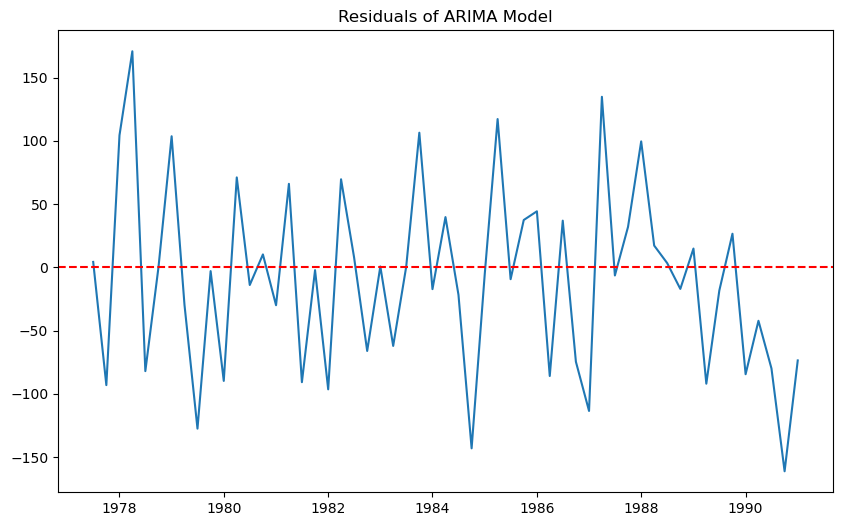

In [27]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Ensure stationarity (apply differencing if necessary)
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(y)
if adf_test[1] > 0.05:
    print("Data is non-stationary, applying differencing.")
    y = y.diff().dropna()

# Fit auto ARIMA
auto_model = auto_arima(y, seasonal=False, trace=True, suppress_warnings=True, error_action='ignore')

# Extract optimal order
p, d, q = auto_model.order

# Fit ARIMA with statsmodels
model = ARIMA(y, order=(p, d, q))
fitted_model = model.fit()
print(fitted_model.summary())

# Residuals
residuals = fitted_model.resid

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals of ARIMA Model")
plt.show()


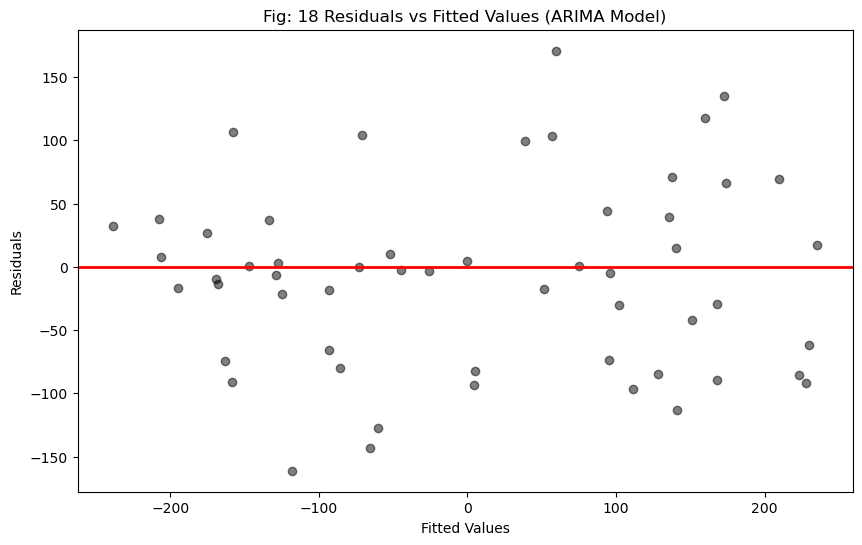

Scatter plot saved to C:/LeonS_Forcasting/Dataset/Figures/18_a_ARIMA_residuals_fitted_plot.svg


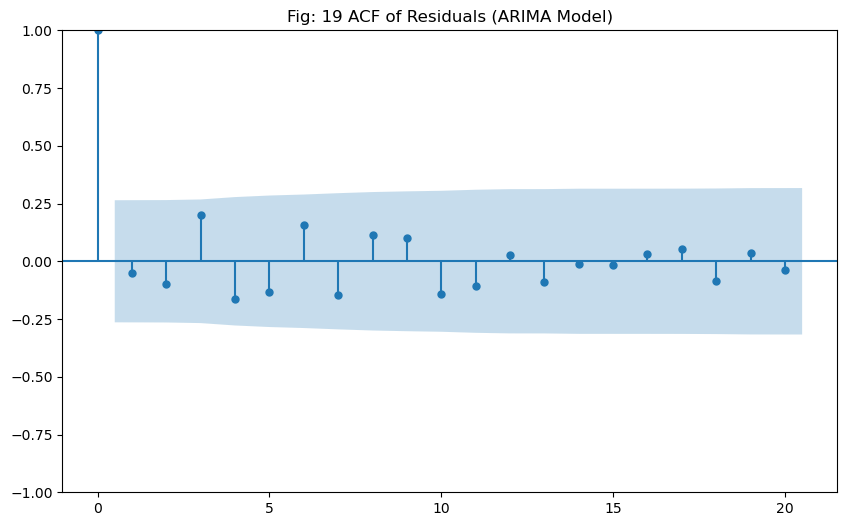

ACF plot saved to C:/LeonS_Forcasting/Dataset/Figures/19_ARIMA_acf_plot.svg


In [28]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Extract residuals from the fitted model
new_residuals = fitted_model.resid  # Ensure this is defined from the ARIMA model

# Residuals vs Fitted Values (Linearity Check)
svg_file_path_residuals_fitted = "C:/LeonS_Forcasting/Dataset/Figures/18_a_ARIMA_residuals_fitted_plot.svg"

plt.figure(figsize=(10, 6))
plt.scatter(fitted_model.fittedvalues, new_residuals, color='black', alpha=0.5)
plt.axhline(0, color='red', linewidth=2)
plt.title("Fig: 18 Residuals vs Fitted Values (ARIMA Model)")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.savefig(svg_file_path_residuals_fitted, format='svg')
plt.show()

print(f"Scatter plot saved to {svg_file_path_residuals_fitted}")

# ACF Plot of Residuals (Independence Check)
svg_file_path_acf = "C:/LeonS_Forcasting/Dataset/Figures/19_ARIMA_acf_plot.svg"

fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(new_residuals, ax=ax, lags=20)
plt.title("Fig: 19 ACF of Residuals (ARIMA Model)")
plt.savefig(svg_file_path_acf, format='svg')
plt.show()

print(f"ACF plot saved to {svg_file_path_acf}")


Shapiro-Wilk Test Statistic: 0.9798016258205396
Shapiro-Wilk Test p-value: 0.4794654783907349
Residuals appear to follow a normal distribution.


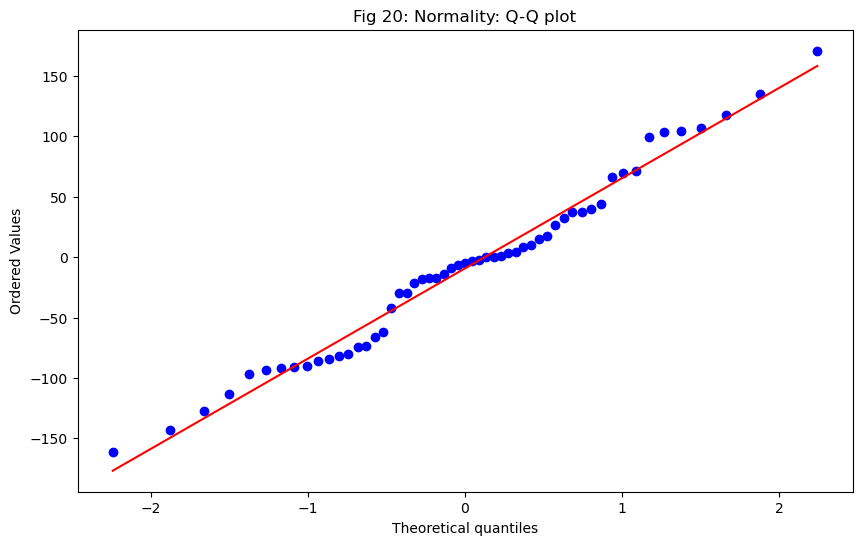

Q-Q plot saved to C:/LeonS_Forcasting/Dataset/Figures/20_ARIMA_qqplot.svg


In [29]:

from scipy.stats import shapiro, probplot

# Shapiro-Wilk Test for Normality
shapiro_test_stat, shapiro_p_value = shapiro(new_residuals)
print(f"Shapiro-Wilk Test Statistic: {shapiro_test_stat}")
print(f"Shapiro-Wilk Test p-value: {shapiro_p_value}")

if shapiro_p_value > 0.05:
    print("Residuals appear to follow a normal distribution.")
else:
    print("Residuals do not follow a normal distribution.")

# Q-Q Plot
svg_file_path_qqplot = "C:/LeonS_Forcasting/Dataset/Figures/20_ARIMA_qqplot.svg"

plt.figure(figsize=(10, 6))
probplot(new_residuals, dist="norm", plot=plt)  # Generates the Q-Q plot
plt.title("Fig 20: Normality: Q-Q plot")
plt.savefig(svg_file_path_qqplot, format='svg')
plt.show()

print(f"Q-Q plot saved to {svg_file_path_qqplot}")


In [30]:

from scipy.stats import shapiro
from statsmodels.stats.diagnostic import acorr_ljungbox

# Shapiro-Wilk Test for Normality
shapiro_stat, shapiro_p_value = shapiro(new_residuals)
print(f"Shapiro-Wilk Test Statistic: {shapiro_stat}")
print(f"Shapiro-Wilk Test p-value: {shapiro_p_value}")

# Ljung-Box Test for Residual Independence (Box Test)
ljungbox_test = acorr_ljungbox(new_residuals, lags=[10], return_df=True)
ljungbox_stat = ljungbox_test['lb_stat'].values[0]
ljungbox_p_value = ljungbox_test['lb_pvalue'].values[0]
print(f"Ljung-Box Test Statistic: {ljungbox_stat}")
print(f"Ljung-Box Test p-value: {ljungbox_p_value}")

# Combine test results into a summary DataFrame
test_results = pd.DataFrame({
    "Test": ["Shapiro-Wilk", "Box-Ljung"],
    "Statistic": [shapiro_stat, ljungbox_stat],
    "P.Value": [shapiro_p_value, ljungbox_p_value]
})

# Display the test results
print(test_results)

# Save the test results to a CSV file if needed
test_results.to_csv("C:/LeonS_Forcasting/Dataset/Figures/21_test_results.csv", index=False)
print("Test results saved to CSV.")


Shapiro-Wilk Test Statistic: 0.9798016258205396
Shapiro-Wilk Test p-value: 0.4794654783907349
Ljung-Box Test Statistic: 11.854281203879456
Ljung-Box Test p-value: 0.29492732970631824
           Test  Statistic   P.Value
0  Shapiro-Wilk   0.979802  0.479465
1     Box-Ljung  11.854281  0.294927
Test results saved to CSV.


Test results table saved as an SVG image at C:/LeonS_Forcasting/Dataset/Figures/22_test_results_table.svg


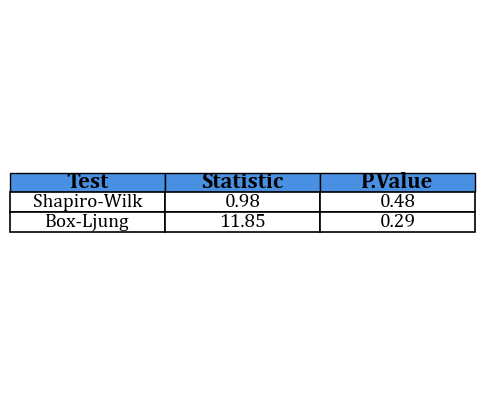

In [31]:

test_results = test_results.round(2)  # Round statistics and p-values to 2 decimals

# Define table styling properties
font_header = FontProperties(family='Cambria', weight='bold', size=16)
font_body = FontProperties(family='Cambria', size=14)
header_color = '#4a90e2'  # Blue color for the header
cell_color = 'white'
text_color = 'black'

# Create the table plot
fig, ax = plt.subplots(figsize=(6, 5))  # Adjust size for better display
ax.axis('tight')
ax.axis('off')

# Add the table to the plot
table_data = ax.table(
    cellText=test_results.values,
    colLabels=test_results.columns,
    loc='center',
    cellLoc='center'
)
table_data.auto_set_font_size(False)
table_data.set_fontsize(14)
table_data.scale(1.0, 1.2)  # Scale table width and height

# Apply header styling
for j in range(len(test_results.columns)):
    cell = table_data[0, j]
    cell.set_text_props(fontproperties=font_header, color=text_color)
    cell.set_facecolor(header_color)
    cell.set_height(0.05)  # Adjust header row height

# Apply body styling
for i in range(1, len(test_results) + 1):
    for j in range(len(test_results.columns)):
        cell = table_data[i, j]
        cell.set_text_props(fontproperties=font_body)
        cell.set_facecolor(cell_color)
        cell.set_edgecolor("black")
        cell.set_linewidth(1.2)  # Increase border thickness

# Define SVG file path and save the table as an SVG file
svg_file_path_table = "C:/LeonS_Forcasting/Dataset/Figures/22_test_results_table.svg"
plt.savefig(svg_file_path_table, format='svg', bbox_inches='tight')

print(f"Test results table saved as an SVG image at {svg_file_path_table}")

# Display the table inline in Jupyter Notebook (optional)
plt.show()


C:\Users\adyle\AppData\Local\Temp\ipykernel_11956\4256701101.py:12: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  forecast_index = pd.date_range(


Forecast plot saved as SVG at: C:/LeonS_Forcasting/Dataset/Figures/23_ArimaForecast_plot.svg


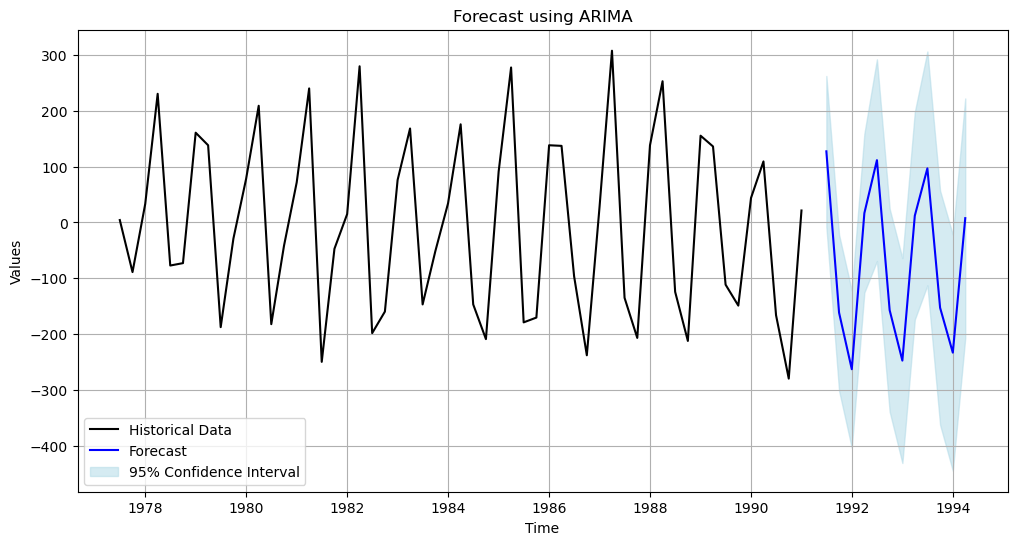

Forecast results saved to CSV at: C:/LeonS_Forcasting/Dataset/Figures/24_Arima_forecast_results.csv


In [32]:

from statsmodels.tsa.arima.model import ARIMA

# Define forecast parameters
forecast_steps = 12  # Number of future periods to forecast

# Forecast using the fitted model
forecast = fitted_model.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean  # Predicted values
conf_int = forecast.conf_int()  # Confidence intervals

# Prepare forecast results for visualization
forecast_index = pd.date_range(
    start=y.index[-1],  # Start forecasting from the end of the historical data
    periods=forecast_steps + 1,  # Include the last point
    freq='Q'  # Change 'Q' to 'M', 'Y', etc., based on your data's frequency
)[1:]  # Skip the first point since it overlaps with the historical data

forecast_series = pd.Series(data=forecast_mean.values, index=forecast_index)

# Plot historical data and forecast
plt.figure(figsize=(12, 6))
plt.plot(y, label="Historical Data", color="black")
plt.plot(forecast_series, label="Forecast", color="blue")
plt.fill_between(
    forecast_index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    color="lightblue",
    alpha=0.5,
    label="95% Confidence Interval"
)
plt.title("Forecast using ARIMA")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.grid(True)

# Save the forecast plot as an SVG file
forecast_plot_path = "C:/LeonS_Forcasting/Dataset/Figures/23_ArimaForecast_plot.svg"
plt.savefig(forecast_plot_path, format='svg', bbox_inches='tight')

print(f"Forecast plot saved as SVG at: {forecast_plot_path}")

# Display the plot inline (optional)
plt.show()

# Prepare the forecast output as a table for further analysis
forecast_results = pd.DataFrame({
    "Forecast": forecast_mean.values,
    "Lower Bound (95%)": conf_int.iloc[:, 0].values,
    "Upper Bound (95%)": conf_int.iloc[:, 1].values
}, index=forecast_index)

# Save forecast results as a CSV file
forecast_csv_path = "C:/LeonS_Forcasting/Dataset/Figures/24_Arima_forecast_results.csv"
forecast_results.to_csv(forecast_csv_path)
print(f"Forecast results saved to CSV at: {forecast_csv_path}")
